<a href="https://colab.research.google.com/github/jgalazka/ERCC_analysis/blob/main/notebooks/GLDS_246_ERCC_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GeneLab ERCC spike-in analysis notebook

This notebook contains an analysis of RNA-seq counts data generated from ERCC spike-ins.

Here GLDS-246 is analyzed.

## Setting up the notebook

In [2]:
# import python packages
import pandas as pd
pd.set_option('mode.chained_assignment', None) # suppress chained indexing warnings
import numpy as np
from urllib.request import urlopen, quote, urlretrieve
from json import loads
from re import search
import zipfile
import seaborn as sns
from scipy.stats import linregress
import matplotlib.pyplot as plt

## GeneLab metadata from URL

Before you begin, visit https://genelab-data.ndc.nasa.gov and browse a GLDS accession # of interest for your analysis.<br>
ISA.zip metadata from URL contains sample ID and transcription profile for RNA-Seq text files used in this analysis. <br>
Function below allows the user to retrieve ISA.zip file without relying on exact version of the data as the versions change.  

In [3]:
# Function to pull metadata zip from GeneLab
# Credit to Kirill Grigorev
GENELAB_ROOT = "https://genelab-data.ndc.nasa.gov"
GLDS_URL_PREFIX = GENELAB_ROOT + "/genelab/data/study/data/"
FILELISTINGS_URL_PREFIX = GENELAB_ROOT + "/genelab/data/study/filelistings/"
ISA_ZIP_REGEX = r'.*_metadata_.*[_-]ISA\.zip$'

def read_json(url):
    with urlopen(url) as response:
        return loads(response.read().decode())

def get_isa(accession):
    glds_json = read_json(GLDS_URL_PREFIX + accession)
    try:
        _id = glds_json[0]["_id"]
    except (AssertionError, TypeError, KeyError, IndexError):
        raise ValueError("Malformed JSON?")
    isa_entries = [
        entry for entry in read_json(FILELISTINGS_URL_PREFIX + _id)
        if search(ISA_ZIP_REGEX, entry["file_name"])
    ]
    if len(isa_entries) == 0:
        raise ValueError("Unexpected: no ISAs found")
    elif len(isa_entries) > 1:
        raise ValueError("Unexpected: multiple files match the ISA regex")
    else:
        entry = isa_entries[0]
        version = entry["version"]
        url = GENELAB_ROOT + entry["remote_url"] + "?version={}".format(version)
        alt_url = (
            GENELAB_ROOT + "/genelab/static/media/dataset/" +
            quote(entry["file_name"]) + "?version={}".format(version)
        )
        return entry["file_name"], version, url, alt_url

The same GLDS accession # contains an unnormalized counts text file used in this analysis. <br>
Function below allows the user to retrieve Unnormalized_Counts.csv without relying on exact version of the data as the versions change.  
> Note: Skip this code block if using Unnormalized_Counts.csv from local

In [4]:
# Function to pull unnormalized counts from GeneLab
# Credit to Kirill Grigorev

RAW_COUNTS_REGEX = r'.*_rna_seq_Unnormalized_Counts.csv'

def get_rawcounts(accession):
    glds_json = read_json(GLDS_URL_PREFIX + accession)
    try:
        _id = glds_json[0]["_id"]
    except (AssertionError, TypeError, KeyError, IndexError):
        raise ValueError("Malformed JSON?")
    raw_counts_entries = [
        entry for entry in read_json(FILELISTINGS_URL_PREFIX + _id)
        if search(RAW_COUNTS_REGEX, entry["file_name"])
    ]
    if len(raw_counts_entries) == 0:
        raise ValueError("Unexpected: no Raw Counts found")
    elif len(raw_counts_entries) > 1:
        raise ValueError("Unexpected: multiple files match the Raw Counts regex")
    else:
        entry = raw_counts_entries[0]
        version = entry["version"]
        url = GENELAB_ROOT + entry["remote_url"] + "?version={}".format(version)
        alt_url = (
            GENELAB_ROOT + "/genelab/static/media/dataset/" +
            quote(entry["file_name"]) + "?version={}".format(version)
        )
        return entry["file_name"], version, url, alt_url

## Get and parse data and metadata
Get and unzip ISA.zip, counts, and ERCC data.

In [5]:
accession = 'GLDS-246' # Change this as necessary
isaurl = get_isa(accession)[3]
filehandle, _ = urlretrieve(isaurl)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
zip_file_object.namelist() # Print contents of zip file. Pick relevant one from list

['s_RR6_SPL.txt',
 'a_rr6_spl_transcription_profiling_RNA_Sequencing_(RNA-Seq).txt',
 'i_Investigation.txt']

There are datasets that have multiple assays (including microarray), so the RNAseq ISA files from the above output must be selected. <br>Txt files outputted above are indexed as 0, 1, 2, etc. Fill in the indexed number corresponding to the sample (s_*txt) and assay files for RNAseq (a_*_(RNA-Seq).txt) in the code block below.

In [6]:
sample_file = zip_file_object.namelist()[0]
file = zip_file_object.open(sample_file)
sample_table = pd.read_csv(zip_file_object.open(sample_file), sep='\t')

assay_file = zip_file_object.namelist()[1]
file = zip_file_object.open(assay_file)
assay_table = pd.read_csv(zip_file_object.open(assay_file), sep='\t')

In [7]:
sample_table.head(n=3)

,Source Name,Sample Name,Characteristics[Organism],Term Source REF,Term Accession Number,Characteristics[Strain],Term Source REF.1,Term Accession Number.1,Comment[Animal Source],Characteristics[sex],Term Source REF.2,Term Accession Number.2,Characteristics[Age at Launch],Unit,Term Source REF.3,Term Accession Number.3,Characteristics[Diet],Term Source REF.4,Term Accession Number.4,Comment[Feeding Schedule],Characteristics[Material Type],Term Source REF.5,Term Accession Number.5,Protocol REF,Parameter Value[Enrichment material],Term Source REF.6,Term Accession Number.6,Factor Value[Spaceflight],Term Source REF.7,Term Accession Number.7,Factor Value[Duration],Unit.1,Term Source REF.8,Term Accession Number.8,Factor Value[Euthanasia Location],Term Source REF.9,Term Accession Number.9,Factor Value[Dissection Condition],Term Source REF.10,Term Accession Number.10,Protocol REF.1,Parameter Value[Euthanasia Method],Term Source REF.11,Term Accession Number.11,Parameter Value[Carcass Preservation Method],Unit.2,Term Source REF.12,Term Accession Number.12,Parameter Value[Carcass Weight],Unit.3,Term Source REF.13,Term Accession Number.13,Parameter Value[Sample Preservation Method],Term Source REF.14,Term Accession Number.14,Parameter Value[Sample Storage Temperature],Unit.4,Term Source REF.15,Term Accession Number.15,Comment[ALSDA Sample Name],Comment[Launch Date],Comment[Euthanasia Date],Comment[Dissection Date],Comment[ALSDA Source Name],Comment[ALSDA Biospecimen Subject ID],Comment[ALSDA Biospecimen ID]
0,LAR Baseline 3,Mmus_C57-6T_SPL_BSL_LAR_Rep1_B3,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,C57BL/6NTac,MEDO,http://www.ebi.ac.uk/efo/medo/MEDO_0000006,Taconic Biosciences,female,EFO,http://purl.obolibrary.org/obo/PATO_0000383,36,week,UO,http://purl.obolibrary.org/obo/UO_0000034,Nutrient Upgraded Rodent Food Bar (NuRFB),NaN,NaN,ad libitum,spleen,UBERON,http://purl.obolibrary.org/obo/UBERON_0002106,animal husbandry,Not Applicable,NCIT,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,Basal Control,NaN,NaN,1,day,UO,http://purl.obolibrary.org/obo/UO_0000033,On Earth,NaN,NaN,Upon euthanasia,NaN,NaN,sample collection,"Isoflurane, Thoracotomy, Cardiac Puncture",NaN,NaN,NaN,NaN,NaN,NaN,30.31,gram,UO,http://purl.obolibrary.org/obo/UO_0000021,Liquid Nitrogen,NCIT,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,-80,degree Celsius,UO,http://purl.obolibrary.org/obo/UO_0000027,Spleen LAR-Base 3,9-Dec-17,9-Dec-17,9-Dec-17,3B18,598,5910
1,LAR Baseline 4,Mmus_C57-6T_SPL_BSL_LAR_Rep2_B4,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,C57BL/6NTac,MEDO,http://www.ebi.ac.uk/efo/medo/MEDO_0000006,Taconic Biosciences,female,EFO,http://purl.obolibrary.org/obo/PATO_0000383,36,week,UO,http://purl.obolibrary.org/obo/UO_0000034,Nutrient Upgraded Rodent Food Bar (NuRFB),NaN,NaN,ad libitum,spleen,UBERON,http://purl.obolibrary.org/obo/UBERON_0002106,animal husbandry,Not Applicable,NCIT,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,Basal Control,NaN,NaN,1,day,UO,http://purl.obolibrary.org/obo/UO_0000033,On Earth,NaN,NaN,Upon euthanasia,NaN,NaN,sample collection,"Isoflurane, Thoracotomy, Cardiac Puncture",NaN,NaN,NaN,NaN,NaN,NaN,27.76,gram,UO,http://purl.obolibrary.org/obo/UO_0000021,Liquid Nitrogen,NCIT,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,-80,degree Celsius,UO,http://purl.obolibrary.org/obo/UO_0000027,Spleen LAR-Base 4,9-Dec-17,9-Dec-17,9-Dec-17,7870,598,5910
2,LAR Baseline 5,Mmus_C57-6T_SPL_BSL_LAR_Rep3_B5,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,C57BL/6NTac,MEDO,http://www.ebi.ac.uk/efo/medo/MEDO_0000006,Taconic Biosciences,female,EFO,http://purl.obolibrary.org/obo/PATO_0000383,36,week,UO,http://purl.obolibrary.org/obo/UO_0000034,Nutrient Upgraded Rodent Food Bar (NuRFB),NaN,NaN,ad libitum,spleen,UBERON,http://purl.obolibrary.org/obo/UBERON_0002106,animal husbandry,Not Applicable,NCIT,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,Basal Control,NaN,NaN,1,day,

In [8]:
pd.set_option('max_columns', None)
assay_table.head(n=3)

,Sample Name,Protocol REF,Parameter Value[QA Instrument],Parameter Value[QA Assay],Parameter Value[QA Score],Unit,Term Source REF,Term Accession Number,Extract Name,Protocol REF.1,Parameter Value[Spike-in Quality Control],Term Source REF.1,Term Accession Number.1,Parameter Value[Spike-in Mix Number],Term Source REF.2,Term Accession Number.2,Protocol REF.2,Parameter Value[library selection],Parameter Value[library layout],Parameter Value[stranded],Parameter Value[Library QA Instrument],Term Source REF.3,Term Accession Number.3,Parameter Value[Library QA Assay],Term Source REF.4,Term Accession Number.4,Parameter Value[Fragment Size],Unit.1,Term Source REF.5,Term Accession Number.5,Protocol REF.3,Parameter Value[sequencing instrument],Parameter Value[base caller],Parameter Value[Read Length],Unit.2,Term Source REF.6,Term Accession Number.6,Assay Name,Parameter Value[rRNA Contamination],Unit.3,Term Source REF.7,Term Accession Number.7,Parameter Value[Read Depth],Unit.4,Term Source REF.8,Term Accession Number.8,Raw Data File,Protocol REF.4,Parameter Value[Fastqc File Names],Term Source REF.9,Term Accession Number.9,Parameter Value[Multiqc File Names],Term Source REF.10,Term Accession Number.10,Parameter Value[trimmed sequence data],Term Source REF.11,Term Accession Number.11,Parameter Value[Trimmed Sequence Data Fastqc File],Term Source REF.12,Term Accession Number.12,Parameter Value[Trimmed Sequence Data Multiqc File],Term Source REF.13,Term Accession Number.13,Parameter Value[Trimmed Report],Term Source REF.14,Term Accession Number.14,Parameter Value[aligned sequence data],Term Source REF.15,Term Accession Number.15,Parameter Value[Alignment Logs],Term Source REF.16,Term Accession Number.16,Parameter Value[Alignment QC Files],Term Source REF.17,Term Accession Number.17,Parameter Value[Raw Counts Data File],Term Source REF.18,Term Accession Number.18,Parameter Value[Normalized Counts Data File],Term Source REF.19,Term Accession Number.19,Parameter Value[differential expression analysis data transformation],Term Source REF.20,Term Accession Number.20,Parameter Value[ERCC Analyses],Term Source REF.21,Term Accession Number.21
0,Mmus_C57-6T_SPL_BSL_LAR_Rep1_B3,nucleic acid extraction,Agilent 2100 Bioanalyzer,RNA 6000 Nano Assay,5.9,RNA Integrity Number,NCIT,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,Mmus_C57-6T_SPL_BSL_LAR_Rep1_B3,spike-in protocol,ERCC ExFold RNA Spike-In Mix,NaN,NaN,Mix 1,NaN,NaN,library construction,Ribo-depletion,PAIRED,STRANDED,Agilent 4200 TapeStation,NaN,NaN,D1000 ScreenTape,NaN,NaN,287,base pair,UO,http://purl.obolibrary.org/obo/UO_0000244,nucleic acid sequencing,Illumina NovaSeq 6000,bcl2fastq,149,base pair,UO,http://purl.obolibrary.org/obo/UO_0000244,rna-seq,0.85,percent,UO,http://purl.obolibrary.org/obo/UO_0000187,106545145,read,SO,http://purl.obolibrary.org/obo/SO_0000150,GLDS-246_rna-seq_Mmus_C57-6T_SPL_BSL_LAR_Rep1_...,GeneLab RNAseq data processing protocol,GLDS-246_rna-seq_Mmus_C57-6T_SPL_BSL_LAR_Rep1_...,NaN,NaN,"GLDS-246_rna-seq_raw_multiqc_report.html, GLDS...",NaN,NaN,GLDS-246_rna_seq_Mmus_C57-6T_SPL_BSL_LAR_Rep1_...,NaN,NaN,GLDS-246_rna_seq_Mmus_C57-6T_SPL_BSL_LAR_Rep1_...,NaN,NaN,"GLDS-246_rna_seq_trimmed_multiqc_report.html, ...",NaN,NaN,GLDS-246_rna_seq_Mmus_C57-6T_SPL_BSL_LAR_Rep1_...,NaN,NaN,GLDS-246_rna_seq_Mmus_C57-6T_SPL_BSL_LAR_Rep1_...,NaN,NaN,GLDS-246_rna_seq_Mmus_C57-6T_SPL_BSL_LAR_Rep1_...,NaN,NaN,GLDS-246_rna_seq_infer_exp_multiqc_report.zip,NaN,NaN,GLDS-246_rna_seq_Mmus_C57-6T_SPL_BSL_LAR_Rep1_...,NaN,NaN,"GLDS-246_rna_seq_Normalized_Counts.csv, GLDS-2...",NaN,NaN,"GLDS-246_rna_seq_contrasts.csv, GLDS-246_rna_s...",NaN,NaN,GLDS-246_rna_seq_ERCC_analysis.html,NaN,NaN
1,Mmus_C57-6T_SPL_BSL_LAR_Rep2_B4,nucleic acid extraction,Agilent 2100 Bioanalyzer,RNA 6000 Nano Assay,6.6,RNA Integrity Number,NCIT,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,Mmus_C57-6T_SPL_BSL_LAR_Rep2_B4,spike-in protocol,ERCC ExFold RNA Spike-In Mix,NaN,NaN,Mix 1,NaN,NaN,library construction,Ribo-deple

In [12]:
# Get raw counts table
raw_counts_file = get_rawcounts(accession)[3] # only if raw counts are pulled from GeneLab Repository using the API
raw_counts_table = pd.read_csv(raw_counts_file, index_col=0)
raw_counts_table.index.rename('Gene_ID', inplace=True)
raw_counts_table.head(n=3)

,Mmus_C57-6T_SPL_BSL_LAR_Rep1_B3,Mmus_C57-6T_SPL_BSL_LAR_Rep2_B4,Mmus_C57-6T_SPL_BSL_LAR_Rep3_B5,Mmus_C57-6T_SPL_BSL_LAR_Rep4_B6,Mmus_C57-6T_SPL_BSL_LAR_Rep5_B7,Mmus_C57-6T_SPL_BSL_LAR_Rep6_B8,Mmus_C57-6T_SPL_BSL_LAR_Rep7_B9,Mmus_C57-6T_SPL_BSL_LAR_Rep8_B10,Mmus_C57-6T_SPL_BSL_LAR_Rep9_B1,Mmus_C57-6T_SPL_BSL_LAR_Rep10_B2,Mmus_C57-6T_SPL_GC_LAR_Rep1_G3,Mmus_C57-6T_SPL_GC_LAR_Rep2_G4,Mmus_C57-6T_SPL_GC_LAR_Rep3_G5,Mmus_C57-6T_SPL_GC_LAR_Rep4_G6,Mmus_C57-6T_SPL_GC_LAR_Rep5_G7,Mmus_C57-6T_SPL_GC_LAR_Rep6_G8,Mmus_C57-6T_SPL_GC_LAR_Rep7_G9,Mmus_C57-6T_SPL_GC_LAR_Rep8_G10,Mmus_C57-6T_SPL_GC_LAR_Rep9_G2,Mmus_C57-6T_SPL_FLT_LAR_Rep1_F3,Mmus_C57-6T_SPL_FLT_LAR_Rep2_F4,Mmus_C57-6T_SPL_FLT_LAR_Rep3_F5,Mmus_C57-6T_SPL_FLT_LAR_Rep4_F6,Mmus_C57-6T_SPL_FLT_LAR_Rep5_F7,Mmus_C57-6T_SPL_FLT_LAR_Rep6_F8,Mmus_C57-6T_SPL_FLT_LAR_Rep7_F9,Mmus_C57-6T_SPL_FLT_LAR_Rep8_F10,Mmus_C57-6T_SPL_BSL_ISS-T_Rep1_B6,Mmus_C57-6T_SPL_BSL_ISS-T_Rep2_B7,Mmus_C57-6T_SPL_BSL_ISS-T_Rep3_B8,Mmus_C57-6T_SPL_GC_ISS-T_Rep1_G3,Mmus_C57-6T_SPL_GC_ISS-T_Rep2_G4,Mmus_C57-6T_SPL_GC_ISS-T_Rep3_G5,Mmus_C57-6T_SPL_GC_ISS-T_Rep4_G6,Mmus_C57-6T_SPL_GC_ISS-T_Rep5_G8,Mmus_C57-6T_SPL_GC_ISS-T_Rep6_G9,Mmus_C57-6T_SPL_GC_ISS-T_Rep7_G10,Mmus_C57-6T_SPL_FLT_ISS-T_Rep1_F3,Mmus_C57-6T_SPL_FLT_ISS-T_Rep2_F4,Mmus_C57-6T_SPL_FLT_ISS-T_Rep3_F5,Mmus_C57-6T_SPL_FLT_ISS-T_Rep4_F7,Mmus_C57-6T_SPL_FLT_ISS-T_Rep5_F8,Mmus_C57-6T_SPL_FLT_ISS-T_Rep6_F9,Mmus_C57-6T_SPL_FLT_ISS-T_Rep7_F10
Gene_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000001,1303.0,1156.0,3255.0,2822.0,3245.0,3244.0,2054.0,1643.0,2454.0,2979.0,2801.0,2563.0,3276.0,2938.0,3328.0,2132.0,2692.0,2756.0,2889.0,2955.0,2250.0,4302.0,3039.0,1144.0,3323.0,3234.0,1841.0,3099.0,2415.0,4667.0,3304.0,2807.0,3308.0,3405.0,3855.0,2596.0,3792.0,2956.0,2855.0,4122.0,3542.0,3044.0,2037.0,5654.0
ENSMUSG00000000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000000028,313.0,268.0,981.0,683.0,625.0,351.0,372.0,289.0,497.0,848.0,290.0,449.0,443.0,298.0,271.0,680.0,201.0,206.0,278.0,273.0,354.0,467.0,196.0,75.0,195.0,274.0,353.0,822.0,465.0,975.0,450.0,578.0,698.0,356.0,268.0,177.0,346.0,695.0,555.0,959.0,310.0,517.0,167.0,570.0


In [13]:
raw_counts_transcripts = raw_counts_table[raw_counts_table.index.str.contains('^ENSMUSG')]
raw_counts_transcripts = raw_counts_transcripts.sort_values(by=list(raw_counts_transcripts), ascending=False)
raw_counts_transcripts

,Mmus_C57-6T_SPL_BSL_LAR_Rep1_B3,Mmus_C57-6T_SPL_BSL_LAR_Rep2_B4,Mmus_C57-6T_SPL_BSL_LAR_Rep3_B5,Mmus_C57-6T_SPL_BSL_LAR_Rep4_B6,Mmus_C57-6T_SPL_BSL_LAR_Rep5_B7,Mmus_C57-6T_SPL_BSL_LAR_Rep6_B8,Mmus_C57-6T_SPL_BSL_LAR_Rep7_B9,Mmus_C57-6T_SPL_BSL_LAR_Rep8_B10,Mmus_C57-6T_SPL_BSL_LAR_Rep9_B1,Mmus_C57-6T_SPL_BSL_LAR_Rep10_B2,Mmus_C57-6T_SPL_GC_LAR_Rep1_G3,Mmus_C57-6T_SPL_GC_LAR_Rep2_G4,Mmus_C57-6T_SPL_GC_LAR_Rep3_G5,Mmus_C57-6T_SPL_GC_LAR_Rep4_G6,Mmus_C57-6T_SPL_GC_LAR_Rep5_G7,Mmus_C57-6T_SPL_GC_LAR_Rep6_G8,Mmus_C57-6T_SPL_GC_LAR_Rep7_G9,Mmus_C57-6T_SPL_GC_LAR_Rep8_G10,Mmus_C57-6T_SPL_GC_LAR_Rep9_G2,Mmus_C57-6T_SPL_FLT_LAR_Rep1_F3,Mmus_C57-6T_SPL_FLT_LAR_Rep2_F4,Mmus_C57-6T_SPL_FLT_LAR_Rep3_F5,Mmus_C57-6T_SPL_FLT_LAR_Rep4_F6,Mmus_C57-6T_SPL_FLT_LAR_Rep5_F7,Mmus_C57-6T_SPL_FLT_LAR_Rep6_F8,Mmus_C57-6T_SPL_FLT_LAR_Rep7_F9,Mmus_C57-6T_SPL_FLT_LAR_Rep8_F10,Mmus_C57-6T_SPL_BSL_ISS-T_Rep1_B6,Mmus_C57-6T_SPL_BSL_ISS-T_Rep2_B7,Mmus_C57-6T_SPL_BSL_ISS-T_Rep3_B8,Mmus_C57-6T_SPL_GC_ISS-T_Rep1_G3,Mmus_C57-6T_SPL_GC_ISS-T_Rep2_G4,Mmus_C57-6T_SPL_GC_ISS-T_Rep3_G5,Mmus_C57-6T_SPL_GC_ISS-T_Rep4_G6,Mmus_C57-6T_SPL_GC_ISS-T_Rep5_G8,Mmus_C57-6T_SPL_GC_ISS-T_Rep6_G9,Mmus_C57-6T_SPL_GC_ISS-T_Rep7_G10,Mmus_C57-6T_SPL_FLT_ISS-T_Rep1_F3,Mmus_C57-6T_SPL_FLT_ISS-T_Rep2_F4,Mmus_C57-6T_SPL_FLT_ISS-T_Rep3_F5,Mmus_C57-6T_SPL_FLT_ISS-T_Rep4_F7,Mmus_C57-6T_SPL_FLT_ISS-T_Rep5_F8,Mmus_C57-6T_SPL_FLT_ISS-T_Rep6_F9,Mmus_C57-6T_SPL_FLT_ISS-T_Rep7_F10
Gene_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000099250,1442012.90,2333729.97,5037353.39,5824319.49,5779424.42,5512693.27,4969417.96,4126617.62,1176326.63,4118635.01,5620938.75,4545396.83,6998969.07,4178144.68,3648641.37,4473027.76,4204287.28,4844958.45,3350131.71,3430830.99,4618156.55,7149287.15,5653180.60,789680.26,3452235.50,5901582.59,4418501.71,4962820.80,6706829.02,7035406.57,8794139.65,4724506.21,5786369.46,8032642.47,9701554.08,7465758.78,7713654.36,10527922.79,5666850.65,8549873.83,11169860.77,10497738.52,3839961.73,7627926.01
ENSMUSG00000099021,1419294.34,1254167.05,4774946.79,4430781.40,4981125.12,3256916.64,3114845.32,3275993.69,1568668.93,2415233.76,3906241.49,1758630.70,3448879.89,2834534.60,5033978.42,3784559.44,1986071.66,2300374.16,1904972.05,2432796.46,4032029.60,4941768.23,3845223.83,490524.17,1080924.60,3451076.74,2507647.33,4069136.41,5090984.88,5447598.24,6028130.09,4936651.41,4514996.75,4246149.42,6486660.83,4424623.23,4112512.43,2834613.42,6166657.22,7757362.93,4195997.62,5966480.16,709739.57,5024072.91
ENSMUSG00000065037,1049564.27,1344812.55,3581105.20,2963412.43,3225561.70,2750047.20,2142722.11,2637712.34,854298.18,1486707.37,2306361.20,1615343.71,3468067.06,1878705.89,1951518.11,1663119.97,1582073.89,1801166.28,1610764.46,1653182.84,2544486.87,4036139.53,2846773.48,426969.66,1834065.21,2398696.15,1637689.76,1857051.90,2161518.37,2713140.62,3292065.91,3006627.87,2832545.54,1599095.90,3136134.37,2083978.17,2581714.59,3200820.79,3101383.38,4359540.80,2486537.46,1936104.88,792182.07,3093962.99
ENSMUSG00000064339,949589.00,1034826.03,2570489.00,2434103.00,2528832.00,2421323.00,2353462.00,1449446.00,1217321.00,2359515.00,1874338.00,1585824.00,2650829.00,1760908.00,2145872.00,2014501.00,2027589.00,2211973.00,2493530.00,1515712.00,1890510.00,2336416.10,1699813.00,607492.00,2528679.00,4806754.02,1742657.00,2898603.00,2934694.00,2744101.00,2902020.00,1939311.00,2371332.00,3377601.00,2797670.00,3651079.00,3518857.00,2404969.05,2263278.00,5947332.00,4522649.00,3777518.00,1664174.00,3554452.00
ENSMUSG00000075015,703302.40,691449.91,401.78,2807.03,370.39,24089.92,112.02,419877.47,279519.90,272.44,35.68,165912.55,1498.41,15.00,498.56,1283.75,153.62,74.98,1469.92,36.57,139.78,198.34,177.13,412086.74,39.40,44.90,12.98,6894.15,31.89,9.99,193.72,291829.13,49369.58,23.00,2546.78,94.73,27.49,10416.98,179.95,54.80,34.83,11.91,792363.53,15.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [14]:
# Get ERCC counts
ercc_counts = raw_counts_table[raw_counts_table.index.str.contains('^ERCC-')] 
ercc_counts.reset_index(inplace=True)
ercc_counts = ercc_counts.rename(columns={'Gene_ID':'ERCC ID'})
ercc_counts = ercc_counts.sort_values(by=list(ercc_counts), ascending=False)
ercc_counts.head()

,ERCC ID,Mmus_C57-6T_SPL_BSL_LAR_Rep1_B3,Mmus_C57-6T_SPL_BSL_LAR_Rep2_B4,Mmus_C57-6T_SPL_BSL_LAR_Rep3_B5,Mmus_C57-6T_SPL_BSL_LAR_Rep4_B6,Mmus_C57-6T_SPL_BSL_LAR_Rep5_B7,Mmus_C57-6T_SPL_BSL_LAR_Rep6_B8,Mmus_C57-6T_SPL_BSL_LAR_Rep7_B9,Mmus_C57-6T_SPL_BSL_LAR_Rep8_B10,Mmus_C57-6T_SPL_BSL_LAR_Rep9_B1,Mmus_C57-6T_SPL_BSL_LAR_Rep10_B2,Mmus_C57-6T_SPL_GC_LAR_Rep1_G3,Mmus_C57-6T_SPL_GC_LAR_Rep2_G4,Mmus_C57-6T_SPL_GC_LAR_Rep3_G5,Mmus_C57-6T_SPL_GC_LAR_Rep4_G6,Mmus_C57-6T_SPL_GC_LAR_Rep5_G7,Mmus_C57-6T_SPL_GC_LAR_Rep6_G8,Mmus_C57-6T_SPL_GC_LAR_Rep7_G9,Mmus_C57-6T_SPL_GC_LAR_Rep8_G10,Mmus_C57-6T_SPL_GC_LAR_Rep9_G2,Mmus_C57-6T_SPL_FLT_LAR_Rep1_F3,Mmus_C57-6T_SPL_FLT_LAR_Rep2_F4,Mmus_C57-6T_SPL_FLT_LAR_Rep3_F5,Mmus_C57-6T_SPL_FLT_LAR_Rep4_F6,Mmus_C57-6T_SPL_FLT_LAR_Rep5_F7,Mmus_C57-6T_SPL_FLT_LAR_Rep6_F8,Mmus_C57-6T_SPL_FLT_LAR_Rep7_F9,Mmus_C57-6T_SPL_FLT_LAR_Rep8_F10,Mmus_C57-6T_SPL_BSL_ISS-T_Rep1_B6,Mmus_C57-6T_SPL_BSL_ISS-T_Rep2_B7,Mmus_C57-6T_SPL_BSL_ISS-T_Rep3_B8,Mmus_C57-6T_SPL_GC_ISS-T_Rep1_G3,Mmus_C57-6T_SPL_GC_ISS-T_Rep2_G4,Mmus_C57-6T_SPL_GC_ISS-T_Rep3_G5,Mmus_C57-6T_SPL_GC_ISS-T_Rep4_G6,Mmus_C57-6T_SPL_GC_ISS-T_Rep5_G8,Mmus_C57-6T_SPL_GC_ISS-T_Rep6_G9,Mmus_C57-6T_SPL_GC_ISS-T_Rep7_G10,Mmus_C57-6T_SPL_FLT_ISS-T_Rep1_F3,Mmus_C57-6T_SPL_FLT_ISS-T_Rep2_F4,Mmus_C57-6T_SPL_FLT_ISS-T_Rep3_F5,Mmus_C57-6T_SPL_FLT_ISS-T_Rep4_F7,Mmus_C57-6T_SPL_FLT_ISS-T_Rep5_F8,Mmus_C57-6T_SPL_FLT_ISS-T_Rep6_F9,Mmus_C57-6T_SPL_FLT_ISS-T_Rep7_F10
91,ERCC-00171,11422.0,9088.0,19534.0,17750.0,19619.0,26280.0,17111.0,10504.0,11318.0,14034.0,17834.0,15080.0,12246.0,18889.0,18782.0,22018.0,14574.0,15641.0,14889.0,13729.0,21142.0,28495.0,28921.0,16766.0,17627.0,18594.0,15548.0,22497.0,33176.0,28471.0,32274.0,24528.0,37617.0,38147.0,39330.0,27942.0,23937.0,19628.0,20724.0,31049.0,42521.0,38409.0,17452.0,31882.0
90,ERCC-00170,86.0,58.0,217.0,132.0,178.0,165.0,120.0,68.0,65.0,130.0,154.0,107.0,114.0,153.0,142.0,170.0,102.0,127.0,112.0,28.0,42.0,68.0,59.0,23.0,30.0,47.0,26.0,43.0,79.0,53.0,75.0,53.0,66.0,64.0,67.0,48.0,65.0,153.0,129.0,295.0,342.0,303.0,139.0,270.0
89,ERCC-00168,2.0,1.0,5.0,4.0,2.0,1.0,8.0,5.0,3.0,3.0,4.0,7.0,3.0,2.0,2.0,4.0,3.0,3.0,1.0,6.0,15.0,23.0,15.0,8.0,13.0,8.0,7.0,7.0,16.0,19.0,18.0,12.0,20.0,17.0,25.0,9.0,8.0,7.0,8.0,9.0,10.0,16.0,4.0,9.0
88,ERCC-00165,272.0,236.0,552.0,502.0,577.0,822.0,531.0,302.0,311.0,385.0,545.0,403.0,401.0,483.0,514.0,692.0,395.0,399.0,425.0,749.0,1172.0,1703.0,1781.0,797.0,1064.0,1049.0,825.0,1322.0,1912.0,1599.0,1844.0,1253.0,1965.0,1999.0,2331.0,1563.0,1309.0,596.0,600.0,918.0,1235.0,1033.0,395.0,824.0
87,ERCC-00164,2.0,4.0,1.0,4.0,5.0,2.0,2.0,2.0,3.0,1.0,0.0,1.0,2.0,10.0,2.0,2.0,1.0,1.0,3.0,2.0,4.0,7.0,6.0,2.0,2.0,9.0,1.0,9.0,9.0,12.0,11.0,3.0,7.0,6.0,12.0,9.0,8.0,2.0,3.0,5.0,8.0,5.0,2.0,3.0


In [15]:
# Get ERCC files
ercc_url = 'https://assets.thermofisher.com/TFS-Assets/LSG/manuals/cms_095046.txt'
filehandle, _ = urlretrieve(ercc_url)
ercc_table = pd.read_csv(filehandle, '\t')
ercc_table.head(n=3)

,Re-sort ID,ERCC ID,subgroup,concentration in Mix 1 (attomoles/ul),concentration in Mix 2 (attomoles/ul),expected fold-change ratio,log2(Mix 1/Mix 2)
0,1,ERCC-00130,A,30000.0,7500.00,4.0,2.0
1,2,ERCC-00004,A,7500.0,1875.00,4.0,2.0
2,3,ERCC-00136,A,1875.0,468.75,4.0,2.0


## Number of ERCC Detected 
Number of ERCC detected in each of the 4 (A, B, C and D) groups for the study. 

Filter counts > 0

In [16]:
meltERCC = ercc_counts.melt(id_vars=['ERCC ID'])
meltERCC['log2 Count'] = meltERCC['value']+1
meltERCC['log2 Count'] = np.log2(meltERCC['log2 Count'])
meltERCC = meltERCC.rename(columns={'variable':'Sample Name', 'value':'Count'})
meltERCC.head(n=3)

,ERCC ID,Sample Name,Count,log2 Count
0,ERCC-00171,Mmus_C57-6T_SPL_BSL_LAR_Rep1_B3,11422.0,13.479654
1,ERCC-00170,Mmus_C57-6T_SPL_BSL_LAR_Rep1_B3,86.0,6.442943
2,ERCC-00168,Mmus_C57-6T_SPL_BSL_LAR_Rep1_B3,2.0,1.584963


In [17]:
# Build Mix dictionary to link sample name to mix added using assay table
mix_dict = assay_table.filter(['Sample Name','Parameter Value[Spike-in Mix Number]', 
                       'Parameter Value[Read Depth]'])
mix_dict = mix_dict.rename(columns={'Parameter Value[Spike-in Mix Number]':'Mix',
                                    'Parameter Value[Read Depth]':
                                    'Total Reads'})
mix_dict.head(n=3)

,Sample Name,Mix,Total Reads
0,Mmus_C57-6T_SPL_BSL_LAR_Rep1_B3,Mix 1,106545145
1,Mmus_C57-6T_SPL_BSL_LAR_Rep2_B4,Mix 1,111068823
2,Mmus_C57-6T_SPL_BSL_LAR_Rep3_B5,Mix 1,110761283


In [18]:
# Make combined ercc counts and assay table
merged_ercc = meltERCC.merge(mix_dict, on='Sample Name')
merged_ercc.head(n=3)

,ERCC ID,Sample Name,Count,log2 Count,Mix,Total Reads
0,ERCC-00171,Mmus_C57-6T_SPL_BSL_LAR_Rep1_B3,11422.0,13.479654,Mix 1,106545145
1,ERCC-00170,Mmus_C57-6T_SPL_BSL_LAR_Rep1_B3,86.0,6.442943,Mix 1,106545145
2,ERCC-00168,Mmus_C57-6T_SPL_BSL_LAR_Rep1_B3,2.0,1.584963,Mix 1,106545145


In [19]:
# Read ERCC info including concentrations from merged_ercc table
groupA = ercc_table.loc[ercc_table['subgroup'] == 'A']['ERCC ID']
groupB = ercc_table.loc[ercc_table['subgroup'] == 'B']['ERCC ID']
groupC = ercc_table.loc[ercc_table['subgroup'] == 'C']['ERCC ID']
groupD = ercc_table.loc[ercc_table['subgroup'] == 'D']['ERCC ID']

# Make a dictionary for ERCC group
group_dict = dict(zip(ercc_table['ERCC ID'], ercc_table['subgroup']))

In [20]:
# Calculate Count per million and log2 Count per million
merged_ercc['Count per million'] = merged_ercc['Count'] / (merged_ercc['Total Reads'] / 1000000.0)
merged_ercc['log2 Count per million'] = np.log2(merged_ercc['Count per million']+1)

# Add ERCC group
merged_ercc['ERCC group'] = merged_ercc['ERCC ID'].map(group_dict)
merged_ercc = merged_ercc.sort_values(by=['Mix'], ascending=True)
merged_ercc

,ERCC ID,Sample Name,Count,log2 Count,Mix,Total Reads,Count per million,log2 Count per million,ERCC group
0,ERCC-00171,Mmus_C57-6T_SPL_BSL_LAR_Rep1_B3,11422.0,13.479654,Mix 1,106545145,107.203383,6.757602,B
1591,ERCC-00120,Mmus_C57-6T_SPL_GC_LAR_Rep8_G10,2.0,1.584963,Mix 1,99540537,0.020092,0.028700,C
1592,ERCC-00117,Mmus_C57-6T_SPL_GC_LAR_Rep8_G10,1.0,1.000000,Mix 1,99540537,0.010046,0.014421,B
1593,ERCC-00116,Mmus_C57-6T_SPL_GC_LAR_Rep8_G10,8247.0,13.009829,Mix 1,99540537,82.850668,6.389750,A
1594,ERCC-00113,Mmus_C57-6T_SPL_GC_LAR_Rep8_G10,27166.0,14.729568,Mix 1,99540537,272.913939,8.097579,C
...,...,...,...,...,...,...,...,...,...
2515,ERCC-00112,Mmus_C57-6T_SPL_BSL_ISS-T_Rep1_B6,3625.0,11.824163,Mix 2,117225942,30.923189,4.996533,D
2516,ERCC-00111,Mmus_C57-6T_SPL_BSL_ISS-T_Rep1_B6,9671.0,13.239599,Mix 2,117225942,82.498804,6.383684,C
2517,ERCC-00109,Mmus_C57-6T_SPL_BSL_ISS-T_Rep1_B6,5.0,2.584963,Mix 2,117225942,0.042653,0.060259,B
2511,ERCC-00120,Mmus_C57-6T_SPL_BSL_ISS-T_Rep1_B6,4.0,2.321928,Mix 2,117225942,0.034122,0.048407,C


Filter and calculate mean Count per million of Mix1 and Mix2 in each of the 4 groups

In [21]:
# Filter Mix1 CPM and Mix2 CPM in group A 
# Mean values of Mix1 CPM and Mix2 CPM
Adf = merged_ercc.loc[merged_ercc['ERCC group'] == 'A']
Amix1df = Adf.loc[Adf['Mix']=='Mix 1']
Amix1df['Mix1 CPM'] = Amix1df[Amix1df['Count per million'] > 0]['Count per million'].dropna()
Amix1df = Amix1df.groupby('ERCC ID')['Mix1 CPM'].agg(np.mean).rename('Avg Mix1 CPM')
Amix1df = Amix1df.to_frame()
Amix2df = Adf.loc[Adf['Mix']=='Mix 2']
Amix2df['Mix2 CPM'] = Amix2df[Amix2df['Count per million'] > 0]['Count per million'].dropna()
Amix2df = Amix2df.groupby('ERCC ID')['Mix2 CPM'].agg(np.mean).rename('Avg Mix2 CPM')
Amix2df = Amix2df.to_frame()

adf = Amix1df.merge(Amix2df, on='ERCC ID', suffixes=('', '_2'))
adf = adf.reset_index()
adf['Avg Mix1 CPM/ Avg Mix2 CPM'] = (adf['Avg Mix1 CPM'] / adf['Avg Mix2 CPM'])

In [22]:
Bdf = merged_ercc.loc[merged_ercc['ERCC group'] == 'B']
Bmix1df = Bdf.loc[Bdf['Mix']=='Mix 1']
Bmix1df['Mix1 CPM'] = Bmix1df[Bmix1df['Count per million'] > 0]['Count per million'].dropna()
Bmix1df = Bmix1df.groupby('ERCC ID')['Mix1 CPM'].agg(np.mean).rename('Avg Mix1 CPM')
Bmix1df = Bmix1df.to_frame()
Bmix2df = Bdf.loc[Bdf['Mix']=='Mix 2']
Bmix2df['Mix2 CPM'] = Bmix2df[Bmix2df['Count per million'] > 0]['Count per million'].dropna()
Bmix2df = Bmix2df.groupby('ERCC ID')['Mix2 CPM'].agg(np.mean).rename('Avg Mix2 CPM')
Bmix2df = Bmix2df.to_frame()

bdf = Bmix1df.merge(Bmix2df, on='ERCC ID')
bdf = bdf.reset_index()
bdf['Avg Mix1 CPM/ Avg Mix2 CPM'] = (bdf['Avg Mix1 CPM'] / bdf['Avg Mix2 CPM'])

In [23]:
Cdf = merged_ercc.loc[merged_ercc['ERCC group'] == 'C']
Cmix1df = Cdf.loc[Cdf['Mix']=='Mix 1']
Cmix1df['Mix1 CPM'] = Cmix1df[Cmix1df['Count per million'] > 0]['Count per million'].dropna()
Cmix1df = Cmix1df.groupby('ERCC ID')['Mix1 CPM'].agg(np.mean).rename('Avg Mix1 CPM')
Cmix1df = Cmix1df.to_frame()
Cmix2df = Cdf.loc[Cdf['Mix']=='Mix 2']
Cmix2df['Mix2 CPM'] = Cmix2df[Cmix2df['Count per million'] > 0]['Count per million'].dropna()
Cmix2df = Cmix2df.groupby('ERCC ID')['Mix2 CPM'].agg(np.mean).rename('Avg Mix2 CPM')
Cmix2df = Cmix2df.to_frame()

cdf = Cmix1df.merge(Cmix2df, on='ERCC ID')
cdf = cdf.reset_index()
cdf['Avg Mix1 CPM/ Avg Mix2 CPM'] = (cdf['Avg Mix1 CPM'] / cdf['Avg Mix2 CPM'])

In [24]:
Ddf = merged_ercc.loc[merged_ercc['ERCC group'] == 'D']
Dmix1df = Ddf.loc[Ddf['Mix']=='Mix 1']
Dmix1df['Mix1 CPM'] = Dmix1df[Dmix1df['Count per million'] > 0]['Count per million'].dropna()
Dmix1df = Dmix1df.groupby('ERCC ID')['Mix1 CPM'].agg(np.mean).rename('Avg Mix1 CPM')
Dmix1df = Dmix1df.to_frame()
Dmix2df = Ddf.loc[Ddf['Mix']=='Mix 2']
Dmix2df['Mix2 CPM'] = Dmix2df[Dmix2df['Count per million'] > 0]['Count per million'].dropna()
Dmix2df = Dmix2df.groupby('ERCC ID')['Mix2 CPM'].agg(np.mean).rename('Avg Mix2 CPM')
Dmix2df = Dmix2df.to_frame()

ddf = Dmix1df.merge(Dmix2df, on='ERCC ID')
ddf = ddf.reset_index()
ddf['Avg Mix1 CPM/ Avg Mix2 CPM'] = (ddf['Avg Mix1 CPM'] / ddf['Avg Mix2 CPM'])

Box plots of number of ERCC detected in group A, and bar plot of the average Mix1 CPM / average Mix 2 CPM (for group A we expect Mix 1 CPM / Mix 2 CPM = 4).

Number of ERCC detected in group A (out of 23) = 23


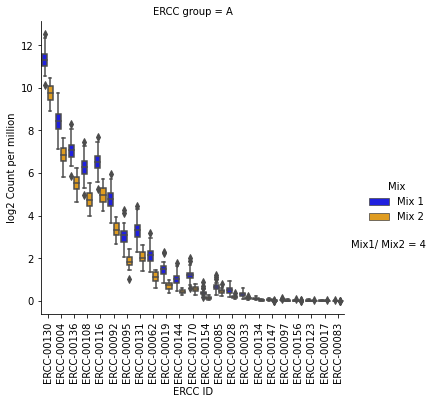

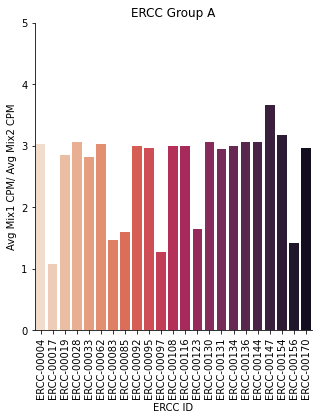

In [25]:
a = sns.catplot(x="ERCC ID", y="log2 Count per million", order=groupA, hue="Mix",data=merged_ercc[merged_ercc['ERCC ID'].isin(groupA)], kind="box", col="ERCC group", height=5, aspect=1, palette=sns.color_palette(['blue', 'orange']))
a.set_xticklabels(rotation=90)
plt.text(23,2.5,"Mix1/ Mix2 = 4")

a1 = sns.catplot(x="ERCC ID", y="Avg Mix1 CPM/ Avg Mix2 CPM", palette="rocket_r", data=adf, kind="bar", height=5, aspect=1, linewidth=0.5)
a1.set_xticklabels(rotation=90)
plt.title("ERCC Group A")
a1.set(ylim=(0, 5))
print('Number of ERCC detected in group A (out of 23) =', adf['Avg Mix1 CPM/ Avg Mix2 CPM'].count())

Box plots of number of ERCC detected in group B, and bar plot of the average Mix1 CPM / average Mix 2 CPM (for group B we expect Mix 1 CPM / Mix 2 CPM = 1).

Number of ERCC detected in group B (out of 23) = 23


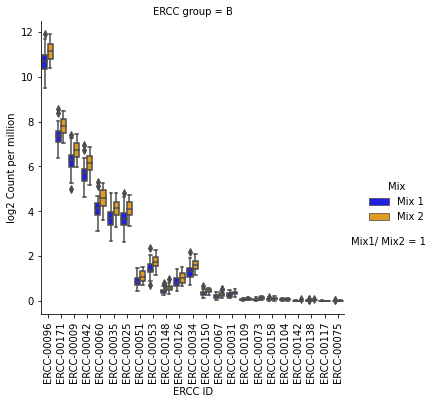

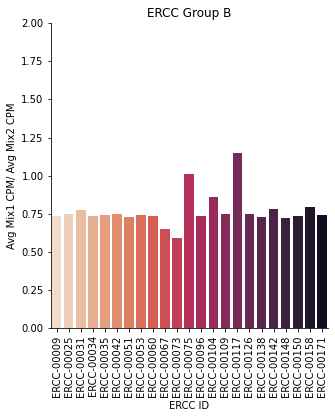

In [26]:
b = sns.catplot(x="ERCC ID", y="log2 Count per million", order=groupB, hue="Mix", data=merged_ercc[merged_ercc['ERCC ID'].isin(groupB)], kind="box", col="ERCC group", height=5, aspect=1, palette=sns.color_palette(['blue', 'orange']))
b.set_xticklabels(rotation=90)
plt.text(23,2.5,"Mix1/ Mix2 = 1")

b = sns.catplot(x="ERCC ID", y="Avg Mix1 CPM/ Avg Mix2 CPM", palette="rocket_r", data=bdf, kind="bar", 
               height=5, aspect=1, linewidth=0.5)
b.set_xticklabels(rotation=90)
plt.title("ERCC Group B")
b.set(ylim=(0, 2))
print('Number of ERCC detected in group B (out of 23) =', bdf['Avg Mix1 CPM/ Avg Mix2 CPM'].count())

Box plots of number of ERCC detected in group C, and bar plot of the average Mix1 CPM / average Mix 2 CPM (for group C we expect Mix 1 CPM / Mix 2 CPM = 0.67).

Number of ERCC detected in group C (out of 23) = 23


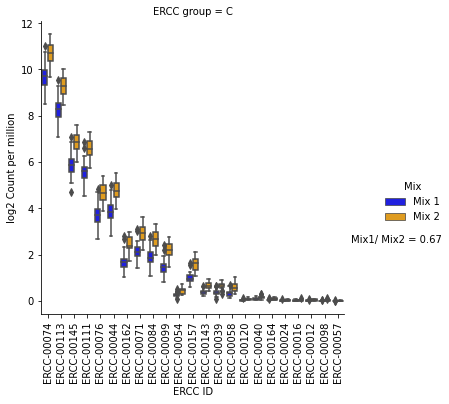

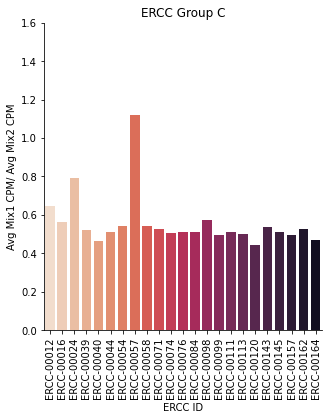

In [27]:
c = sns.catplot(x="ERCC ID", y="log2 Count per million", order=groupC, hue="Mix", data=merged_ercc[merged_ercc['ERCC ID'].isin(groupC)], kind="box", col="ERCC group", height=5, aspect=1, palette=sns.color_palette(['blue', 'orange']))
c.set_xticklabels(rotation=90)
plt.text(23,2.5,"Mix1/ Mix2 = 0.67")

c = sns.catplot(x="ERCC ID", y="Avg Mix1 CPM/ Avg Mix2 CPM", palette="rocket_r", data=cdf, kind="bar", 
               height=5, aspect=1, linewidth=0.5)
c.set_xticklabels(rotation=90)
plt.title("ERCC Group C")
c.set(ylim=(0, 1.6))
print('Number of ERCC detected in group C (out of 23) =', cdf['Avg Mix1 CPM/ Avg Mix2 CPM'].count())

Box plots of number of ERCC detected in group D, and bar plot of the average Mix1 CPM / average Mix 2 CPM (for group D we expect Mix 1 CPM / Mix 2 CPM = 0.5).

Number of ERCC detected in group D (out of 23) = 23


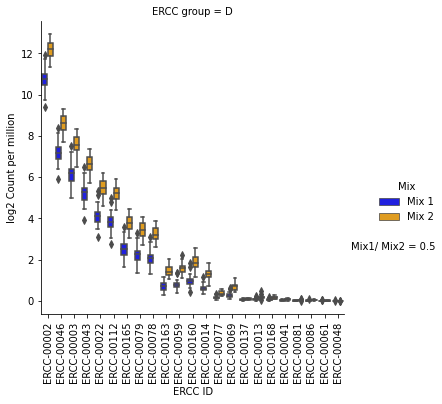

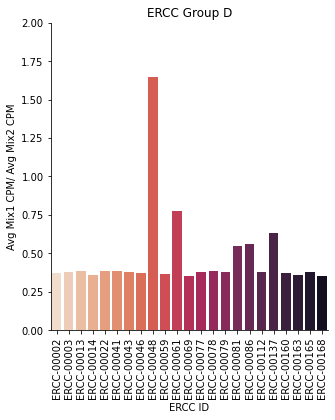

In [28]:
d = sns.catplot(x="ERCC ID", y="log2 Count per million", order=groupD, hue="Mix", data=merged_ercc[merged_ercc['ERCC ID'].isin(groupD)], col="ERCC group", kind="box", height=5, aspect=1, palette=sns.color_palette(['blue', 'orange']))
d.set_xticklabels(rotation=90)
plt.text(23,2.5,"Mix1/ Mix2 = 0.5")

d = sns.catplot(x="ERCC ID", y="Avg Mix1 CPM/ Avg Mix2 CPM", palette="rocket_r", data=ddf, kind="bar", 
               height=5, aspect=1, linewidth=0.5)
d.set_xticklabels(rotation=90)
plt.title("ERCC Group D")
d.set(ylim=(0, 2))
print('Number of ERCC detected in group D (out of 23) =', ddf['Avg Mix1 CPM/ Avg Mix2 CPM'].count())

## Single Sample ERCC Analysis
Calculate and plot ERCC metrics from single samples, including limit of detection, dynamic range, and R^2 of counts vs. concentration.

In [29]:
ercc_table.head(n=3)

,Re-sort ID,ERCC ID,subgroup,concentration in Mix 1 (attomoles/ul),concentration in Mix 2 (attomoles/ul),expected fold-change ratio,log2(Mix 1/Mix 2)
0,1,ERCC-00130,A,30000.0,7500.00,4.0,2.0
1,2,ERCC-00004,A,7500.0,1875.00,4.0,2.0
2,3,ERCC-00136,A,1875.0,468.75,4.0,2.0


In [30]:
# Make a dictionary for ERCC concentrations for each mix
mix1_conc_dict = dict(zip(ercc_table['ERCC ID'], ercc_table['concentration in Mix 1 (attomoles/ul)']))
mix2_conc_dict = dict(zip(ercc_table['ERCC ID'], ercc_table['concentration in Mix 2 (attomoles/ul)']))

Check assay_table header to identify the 'Sample Name' column and the column title indicating the 'Spike-in Mix Nmber' if it's indicated in the metadata.

In [31]:
pd.set_option('max_columns', None)
assay_table.head(n=3)

,Sample Name,Protocol REF,Parameter Value[QA Instrument],Parameter Value[QA Assay],Parameter Value[QA Score],Unit,Term Source REF,Term Accession Number,Extract Name,Protocol REF.1,Parameter Value[Spike-in Quality Control],Term Source REF.1,Term Accession Number.1,Parameter Value[Spike-in Mix Number],Term Source REF.2,Term Accession Number.2,Protocol REF.2,Parameter Value[library selection],Parameter Value[library layout],Parameter Value[stranded],Parameter Value[Library QA Instrument],Term Source REF.3,Term Accession Number.3,Parameter Value[Library QA Assay],Term Source REF.4,Term Accession Number.4,Parameter Value[Fragment Size],Unit.1,Term Source REF.5,Term Accession Number.5,Protocol REF.3,Parameter Value[sequencing instrument],Parameter Value[base caller],Parameter Value[Read Length],Unit.2,Term Source REF.6,Term Accession Number.6,Assay Name,Parameter Value[rRNA Contamination],Unit.3,Term Source REF.7,Term Accession Number.7,Parameter Value[Read Depth],Unit.4,Term Source REF.8,Term Accession Number.8,Raw Data File,Protocol REF.4,Parameter Value[Fastqc File Names],Term Source REF.9,Term Accession Number.9,Parameter Value[Multiqc File Names],Term Source REF.10,Term Accession Number.10,Parameter Value[trimmed sequence data],Term Source REF.11,Term Accession Number.11,Parameter Value[Trimmed Sequence Data Fastqc File],Term Source REF.12,Term Accession Number.12,Parameter Value[Trimmed Sequence Data Multiqc File],Term Source REF.13,Term Accession Number.13,Parameter Value[Trimmed Report],Term Source REF.14,Term Accession Number.14,Parameter Value[aligned sequence data],Term Source REF.15,Term Accession Number.15,Parameter Value[Alignment Logs],Term Source REF.16,Term Accession Number.16,Parameter Value[Alignment QC Files],Term Source REF.17,Term Accession Number.17,Parameter Value[Raw Counts Data File],Term Source REF.18,Term Accession Number.18,Parameter Value[Normalized Counts Data File],Term Source REF.19,Term Accession Number.19,Parameter Value[differential expression analysis data transformation],Term Source REF.20,Term Accession Number.20,Parameter Value[ERCC Analyses],Term Source REF.21,Term Accession Number.21
0,Mmus_C57-6T_SPL_BSL_LAR_Rep1_B3,nucleic acid extraction,Agilent 2100 Bioanalyzer,RNA 6000 Nano Assay,5.9,RNA Integrity Number,NCIT,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,Mmus_C57-6T_SPL_BSL_LAR_Rep1_B3,spike-in protocol,ERCC ExFold RNA Spike-In Mix,NaN,NaN,Mix 1,NaN,NaN,library construction,Ribo-depletion,PAIRED,STRANDED,Agilent 4200 TapeStation,NaN,NaN,D1000 ScreenTape,NaN,NaN,287,base pair,UO,http://purl.obolibrary.org/obo/UO_0000244,nucleic acid sequencing,Illumina NovaSeq 6000,bcl2fastq,149,base pair,UO,http://purl.obolibrary.org/obo/UO_0000244,rna-seq,0.85,percent,UO,http://purl.obolibrary.org/obo/UO_0000187,106545145,read,SO,http://purl.obolibrary.org/obo/SO_0000150,GLDS-246_rna-seq_Mmus_C57-6T_SPL_BSL_LAR_Rep1_...,GeneLab RNAseq data processing protocol,GLDS-246_rna-seq_Mmus_C57-6T_SPL_BSL_LAR_Rep1_...,NaN,NaN,"GLDS-246_rna-seq_raw_multiqc_report.html, GLDS...",NaN,NaN,GLDS-246_rna_seq_Mmus_C57-6T_SPL_BSL_LAR_Rep1_...,NaN,NaN,GLDS-246_rna_seq_Mmus_C57-6T_SPL_BSL_LAR_Rep1_...,NaN,NaN,"GLDS-246_rna_seq_trimmed_multiqc_report.html, ...",NaN,NaN,GLDS-246_rna_seq_Mmus_C57-6T_SPL_BSL_LAR_Rep1_...,NaN,NaN,GLDS-246_rna_seq_Mmus_C57-6T_SPL_BSL_LAR_Rep1_...,NaN,NaN,GLDS-246_rna_seq_Mmus_C57-6T_SPL_BSL_LAR_Rep1_...,NaN,NaN,GLDS-246_rna_seq_infer_exp_multiqc_report.zip,NaN,NaN,GLDS-246_rna_seq_Mmus_C57-6T_SPL_BSL_LAR_Rep1_...,NaN,NaN,"GLDS-246_rna_seq_Normalized_Counts.csv, GLDS-2...",NaN,NaN,"GLDS-246_rna_seq_contrasts.csv, GLDS-246_rna_s...",NaN,NaN,GLDS-246_rna_seq_ERCC_analysis.html,NaN,NaN
1,Mmus_C57-6T_SPL_BSL_LAR_Rep2_B4,nucleic acid extraction,Agilent 2100 Bioanalyzer,RNA 6000 Nano Assay,6.6,RNA Integrity Number,NCIT,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,Mmus_C57-6T_SPL_BSL_LAR_Rep2_B4,spike-in protocol,ERCC ExFold RNA Spike-In Mix,NaN,NaN,Mix 1,NaN,NaN,library construction,Ribo-deple

In [32]:
# get samples that use mix 1 and mix 2
mix1_samples = assay_table[assay_table['Parameter Value[Spike-in Mix Number]'] == 'Mix 1']['Sample Name']
mix2_samples = assay_table[assay_table['Parameter Value[Spike-in Mix Number]'] == 'Mix 2']['Sample Name']

In [33]:
# Get ERCC counts
ercc_counts = raw_counts_table[raw_counts_table.index.str.contains('^ERCC-')] 
ercc_counts = ercc_counts.sort_values(by=list(ercc_counts), ascending=False)
ercc_counts.head()

,Mmus_C57-6T_SPL_BSL_LAR_Rep1_B3,Mmus_C57-6T_SPL_BSL_LAR_Rep2_B4,Mmus_C57-6T_SPL_BSL_LAR_Rep3_B5,Mmus_C57-6T_SPL_BSL_LAR_Rep4_B6,Mmus_C57-6T_SPL_BSL_LAR_Rep5_B7,Mmus_C57-6T_SPL_BSL_LAR_Rep6_B8,Mmus_C57-6T_SPL_BSL_LAR_Rep7_B9,Mmus_C57-6T_SPL_BSL_LAR_Rep8_B10,Mmus_C57-6T_SPL_BSL_LAR_Rep9_B1,Mmus_C57-6T_SPL_BSL_LAR_Rep10_B2,Mmus_C57-6T_SPL_GC_LAR_Rep1_G3,Mmus_C57-6T_SPL_GC_LAR_Rep2_G4,Mmus_C57-6T_SPL_GC_LAR_Rep3_G5,Mmus_C57-6T_SPL_GC_LAR_Rep4_G6,Mmus_C57-6T_SPL_GC_LAR_Rep5_G7,Mmus_C57-6T_SPL_GC_LAR_Rep6_G8,Mmus_C57-6T_SPL_GC_LAR_Rep7_G9,Mmus_C57-6T_SPL_GC_LAR_Rep8_G10,Mmus_C57-6T_SPL_GC_LAR_Rep9_G2,Mmus_C57-6T_SPL_FLT_LAR_Rep1_F3,Mmus_C57-6T_SPL_FLT_LAR_Rep2_F4,Mmus_C57-6T_SPL_FLT_LAR_Rep3_F5,Mmus_C57-6T_SPL_FLT_LAR_Rep4_F6,Mmus_C57-6T_SPL_FLT_LAR_Rep5_F7,Mmus_C57-6T_SPL_FLT_LAR_Rep6_F8,Mmus_C57-6T_SPL_FLT_LAR_Rep7_F9,Mmus_C57-6T_SPL_FLT_LAR_Rep8_F10,Mmus_C57-6T_SPL_BSL_ISS-T_Rep1_B6,Mmus_C57-6T_SPL_BSL_ISS-T_Rep2_B7,Mmus_C57-6T_SPL_BSL_ISS-T_Rep3_B8,Mmus_C57-6T_SPL_GC_ISS-T_Rep1_G3,Mmus_C57-6T_SPL_GC_ISS-T_Rep2_G4,Mmus_C57-6T_SPL_GC_ISS-T_Rep3_G5,Mmus_C57-6T_SPL_GC_ISS-T_Rep4_G6,Mmus_C57-6T_SPL_GC_ISS-T_Rep5_G8,Mmus_C57-6T_SPL_GC_ISS-T_Rep6_G9,Mmus_C57-6T_SPL_GC_ISS-T_Rep7_G10,Mmus_C57-6T_SPL_FLT_ISS-T_Rep1_F3,Mmus_C57-6T_SPL_FLT_ISS-T_Rep2_F4,Mmus_C57-6T_SPL_FLT_ISS-T_Rep3_F5,Mmus_C57-6T_SPL_FLT_ISS-T_Rep4_F7,Mmus_C57-6T_SPL_FLT_ISS-T_Rep5_F8,Mmus_C57-6T_SPL_FLT_ISS-T_Rep6_F9,Mmus_C57-6T_SPL_FLT_ISS-T_Rep7_F10
Gene_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ERCC-00130,158095.0,125241.0,316764.0,269716.0,316124.0,423452.0,277449.0,179421.0,162616.0,209413.0,273656.0,225234.0,202596.0,296275.0,297167.0,345758.0,234823.0,233381.0,241494.0,49115.0,79678.0,111010.0,114442.0,57834.0,69374.0,72043.0,58534.0,85969.0,128111.0,108104.0,123641.0,93755.0,143664.0,141355.0,157658.0,110521.0,88247.0,327144.0,345689.0,489558.0,667795.0,593790.0,259070.0,493641.0
ERCC-00096,99682.0,80487.0,191642.0,173109.0,200475.0,283467.0,179536.0,122496.0,99416.0,122361.0,185269.0,148422.0,126765.0,183875.0,180592.0,228050.0,141887.0,142903.0,143366.0,141359.0,219104.0,298288.0,313282.0,138956.0,177352.0,188553.0,154019.0,232395.0,339027.0,280972.0,339158.0,244250.0,373800.0,366672.0,420914.0,279186.0,221603.0,206545.0,227512.0,318256.0,435803.0,374814.0,152659.0,306861.0
ERCC-00002,90237.0,74520.0,207244.0,182546.0,206279.0,292182.0,190943.0,129542.0,98156.0,134102.0,184123.0,150979.0,133837.0,194152.0,196307.0,236988.0,153847.0,151630.0,152138.0,280085.0,435034.0,596870.0,644796.0,262554.0,369889.0,387471.0,321845.0,465289.0,684510.0,566971.0,675841.0,510174.0,764799.0,737525.0,860674.0,590510.0,465096.0,208286.0,231301.0,324061.0,442326.0,381440.0,152583.0,312443.0
ERCC-00074,53674.0,40470.0,102096.0,81464.0,95002.0,141302.0,93088.0,56496.0,51217.0,71829.0,80288.0,68343.0,63183.0,94495.0,98804.0,114621.0,76129.0,77543.0,78292.0,83845.0,149595.0,196135.0,216730.0,107789.0,137248.0,141264.0,114726.0,166331.0,261792.0,213796.0,242680.0,199514.0,288862.0,292727.0,326577.0,219534.0,183870.0,112299.0,107293.0,163985.0,234612.0,197550.0,87817.0,162039.0
ERCC-00004,20773.0,15344.0,42041.0,33501.0,39613.0,61984.0,41598.0,25953.0,20150.0,28158.0,32316.0,27449.0,26967.0,39869.0,40775.0,48649.0,31028.0,32409.0,33557.0,5751.0,10286.0,13158.0,15872.0,7433.0,9180.0,10045.0,8154.0,11273.0,18273.0,14729.0,16695.0,14390.0,19863.0,20264.0,22265.0,14754.0,12533.0,46418.0,47273.0,68787.0,96913.0,80440.0,35153.0,65958.0


In [34]:
ercc_counts_mix_1 = ercc_counts[mix1_samples]
ercc_counts_mix_1['ERCC conc (attomoles/ul)'] = ercc_counts_mix_1.index.map(mix1_conc_dict)
ercc_counts_mix_1.head(n=3)

,Mmus_C57-6T_SPL_BSL_LAR_Rep1_B3,Mmus_C57-6T_SPL_BSL_LAR_Rep2_B4,Mmus_C57-6T_SPL_BSL_LAR_Rep3_B5,Mmus_C57-6T_SPL_BSL_LAR_Rep4_B6,Mmus_C57-6T_SPL_BSL_LAR_Rep5_B7,Mmus_C57-6T_SPL_BSL_LAR_Rep6_B8,Mmus_C57-6T_SPL_BSL_LAR_Rep7_B9,Mmus_C57-6T_SPL_BSL_LAR_Rep8_B10,Mmus_C57-6T_SPL_BSL_LAR_Rep9_B1,Mmus_C57-6T_SPL_BSL_LAR_Rep10_B2,Mmus_C57-6T_SPL_GC_LAR_Rep1_G3,Mmus_C57-6T_SPL_GC_LAR_Rep2_G4,Mmus_C57-6T_SPL_GC_LAR_Rep3_G5,Mmus_C57-6T_SPL_GC_LAR_Rep4_G6,Mmus_C57-6T_SPL_GC_LAR_Rep5_G7,Mmus_C57-6T_SPL_GC_LAR_Rep6_G8,Mmus_C57-6T_SPL_GC_LAR_Rep7_G9,Mmus_C57-6T_SPL_GC_LAR_Rep8_G10,Mmus_C57-6T_SPL_GC_LAR_Rep9_G2,Mmus_C57-6T_SPL_FLT_ISS-T_Rep1_F3,Mmus_C57-6T_SPL_FLT_ISS-T_Rep2_F4,Mmus_C57-6T_SPL_FLT_ISS-T_Rep3_F5,Mmus_C57-6T_SPL_FLT_ISS-T_Rep4_F7,Mmus_C57-6T_SPL_FLT_ISS-T_Rep5_F8,Mmus_C57-6T_SPL_FLT_ISS-T_Rep6_F9,Mmus_C57-6T_SPL_FLT_ISS-T_Rep7_F10,ERCC conc (attomoles/ul)
Gene_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
ERCC-00130,158095.0,125241.0,316764.0,269716.0,316124.0,423452.0,277449.0,179421.0,162616.0,209413.0,273656.0,225234.0,202596.0,296275.0,297167.0,345758.0,234823.0,233381.0,241494.0,327144.0,345689.0,489558.0,667795.0,593790.0,259070.0,493641.0,30000.0
ERCC-00096,99682.0,80487.0,191642.0,173109.0,200475.0,283467.0,179536.0,122496.0,99416.0,122361.0,185269.0,148422.0,126765.0,183875.0,180592.0,228050.0,141887.0,142903.0,143366.0,206545.0,227512.0,318256.0,435803.0,374814.0,152659.0,306861.0,15000.0
ERCC-00002,90237.0,74520.0,207244.0,182546.0,206279.0,292182.0,190943.0,129542.0,98156.0,134102.0,184123.0,150979.0,133837.0,194152.0,196307.0,236988.0,153847.0,151630.0,152138.0,208286.0,231301.0,324061.0,442326.0,381440.0,152583.0,312443.0,15000.0


In [35]:
ercc_counts_mix_2 = ercc_counts[mix2_samples]
ercc_counts_mix_2['ERCC conc (attomoles/ul)'] = ercc_counts_mix_2.index.map(mix2_conc_dict)
ercc_counts_mix_2.head(n=3)

,Mmus_C57-6T_SPL_FLT_LAR_Rep1_F3,Mmus_C57-6T_SPL_FLT_LAR_Rep2_F4,Mmus_C57-6T_SPL_FLT_LAR_Rep3_F5,Mmus_C57-6T_SPL_FLT_LAR_Rep4_F6,Mmus_C57-6T_SPL_FLT_LAR_Rep5_F7,Mmus_C57-6T_SPL_FLT_LAR_Rep6_F8,Mmus_C57-6T_SPL_FLT_LAR_Rep7_F9,Mmus_C57-6T_SPL_FLT_LAR_Rep8_F10,Mmus_C57-6T_SPL_BSL_ISS-T_Rep1_B6,Mmus_C57-6T_SPL_BSL_ISS-T_Rep2_B7,Mmus_C57-6T_SPL_BSL_ISS-T_Rep3_B8,Mmus_C57-6T_SPL_GC_ISS-T_Rep1_G3,Mmus_C57-6T_SPL_GC_ISS-T_Rep2_G4,Mmus_C57-6T_SPL_GC_ISS-T_Rep3_G5,Mmus_C57-6T_SPL_GC_ISS-T_Rep4_G6,Mmus_C57-6T_SPL_GC_ISS-T_Rep5_G8,Mmus_C57-6T_SPL_GC_ISS-T_Rep6_G9,Mmus_C57-6T_SPL_GC_ISS-T_Rep7_G10,ERCC conc (attomoles/ul)
Gene_ID,,,,,,,,,,,,,,,,,,,
ERCC-00130,49115.0,79678.0,111010.0,114442.0,57834.0,69374.0,72043.0,58534.0,85969.0,128111.0,108104.0,123641.0,93755.0,143664.0,141355.0,157658.0,110521.0,88247.0,7500.0
ERCC-00096,141359.0,219104.0,298288.0,313282.0,138956.0,177352.0,188553.0,154019.0,232395.0,339027.0,280972.0,339158.0,244250.0,373800.0,366672.0,420914.0,279186.0,221603.0,15000.0
ERCC-00002,280085.0,435034.0,596870.0,644796.0,262554.0,369889.0,387471.0,321845.0,465289.0,684510.0,566971.0,675841.0,510174.0,764799.0,737525.0,860674.0,590510.0,465096.0,30000.0


Each sample, either Mix 1 or Mix 2, plotted using scatter plot with x = log2 ERCC conc (attomoles/ ul) and y = log2 Counts.     

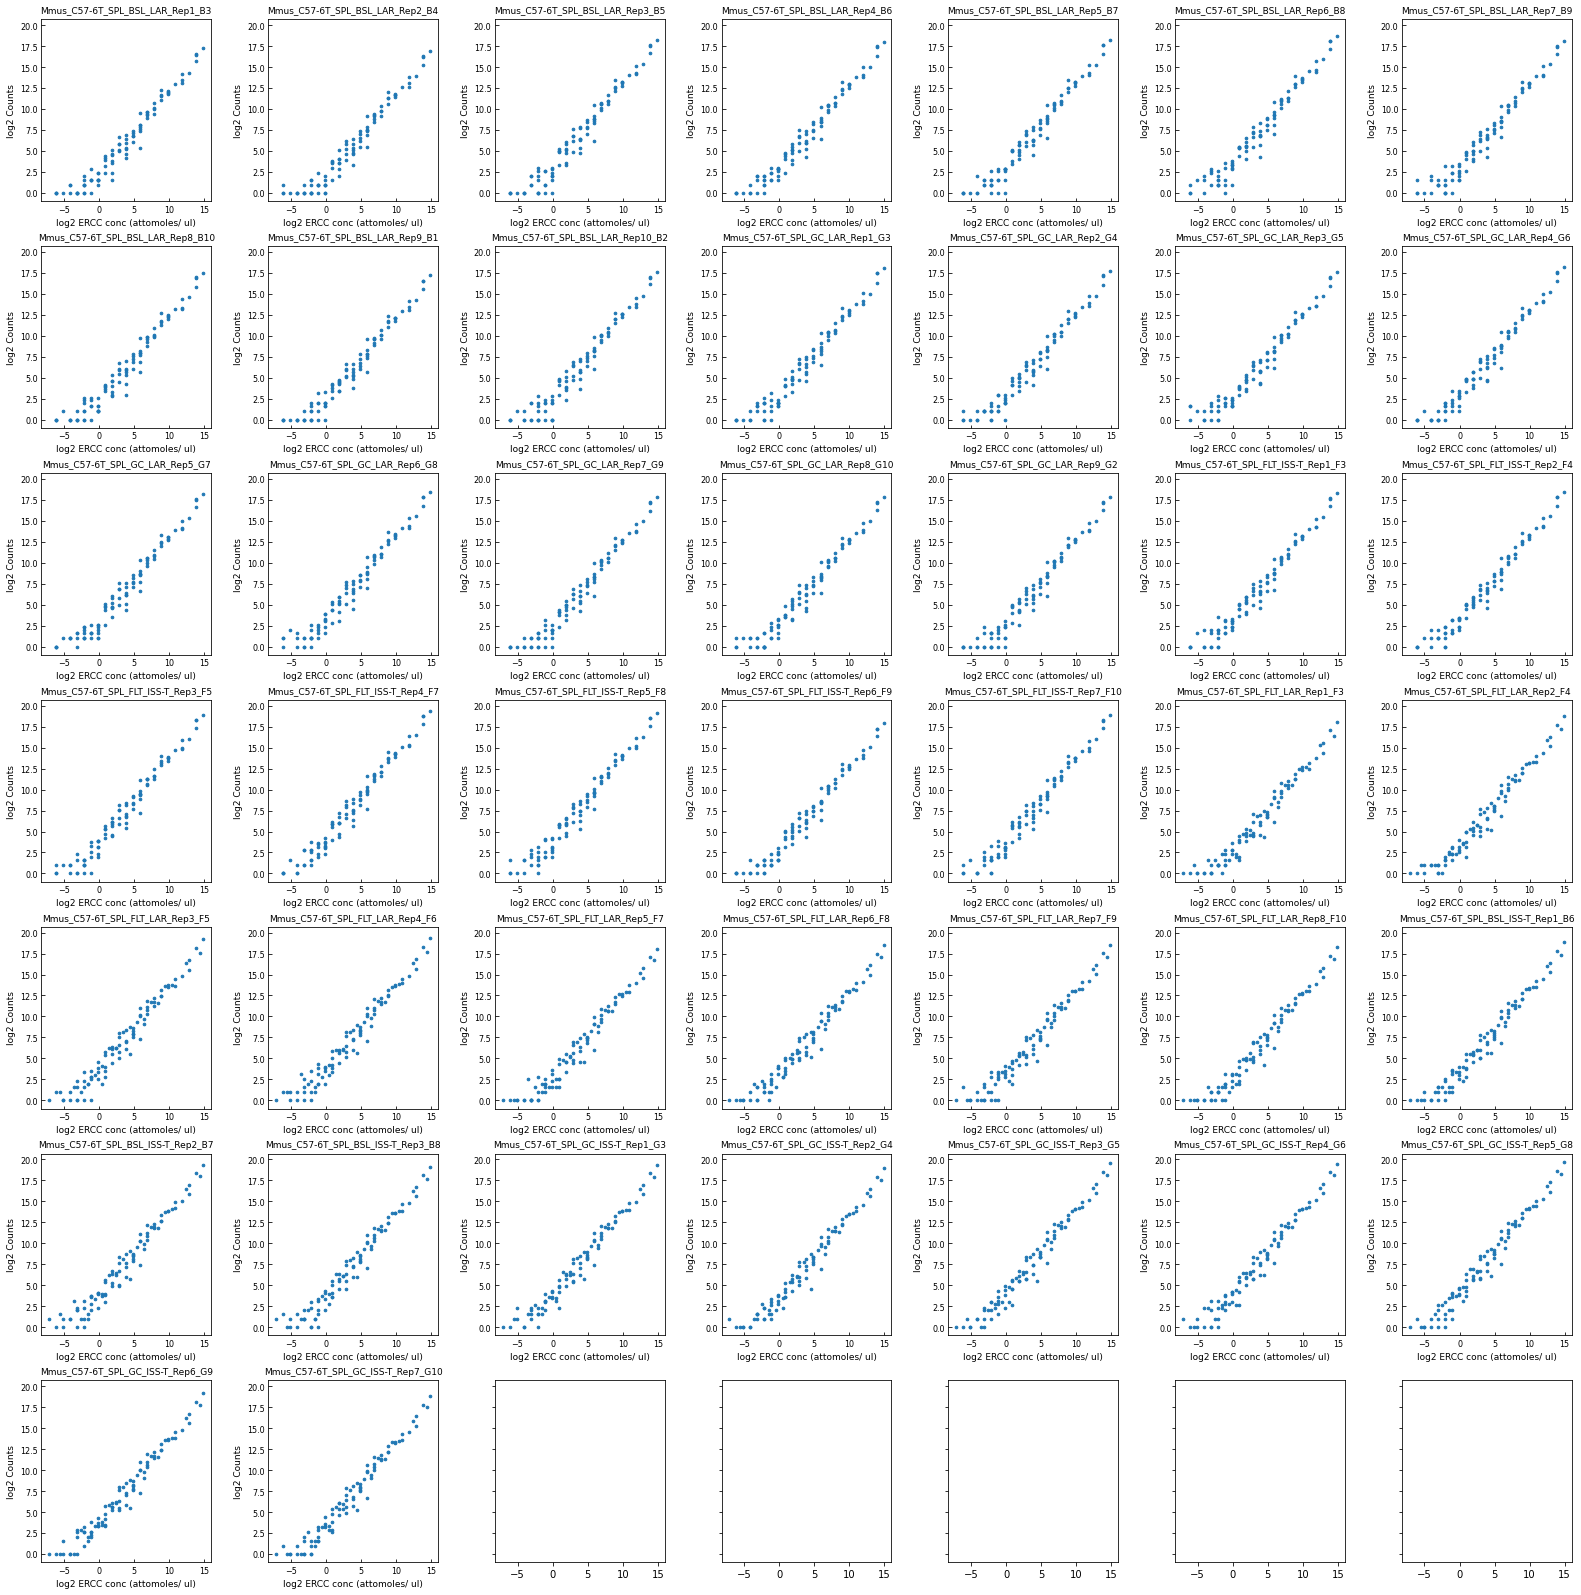

In [36]:
columns_mix_1 = ercc_counts_mix_1.columns.drop(['ERCC conc (attomoles/ul)'])
columns_mix_2 = ercc_counts_mix_2.columns.drop(['ERCC conc (attomoles/ul)'])
all_columns = columns_mix_1.to_list() + columns_mix_2.to_list()
total_columns = len(columns_mix_1) + len(columns_mix_2) 
side_size = np.int32(np.ceil(np.sqrt(total_columns)))# calculate grid side size. take sqrt of total plots and round up.
fig, axs = plt.subplots(side_size, side_size, figsize=(22,22), sharex='all', sharey='all'); #change figsize x,y labels if needed.
fig.tight_layout(pad=1, w_pad=3.5, h_pad=3.5)

counter = 0
for ax in axs.flat:
    
    if(counter < len(columns_mix_1)):
      ax.scatter(x=np.log2(ercc_counts_mix_1['ERCC conc (attomoles/ul)']), y=np.log2(ercc_counts_mix_1[all_columns[counter]]+1), s=7);
      ax.set_title(all_columns[counter][-45:], fontsize=9);
      ax.set_xlabel('log2 ERCC conc (attomoles/ ul)', fontsize=9);
      ax.set_ylabel('log2 Counts', fontsize=9);
      ax.tick_params(direction='in', axis='both', labelsize=8, labelleft=True, labelbottom=True);
      
    elif(counter >= len(columns_mix_1) and counter < total_columns):
      ax.scatter(x=np.log2(ercc_counts_mix_2['ERCC conc (attomoles/ul)']), y=np.log2(ercc_counts_mix_2[all_columns[counter]]+1), s=7);
      ax.set_title(all_columns[counter][-45:], fontsize=9);
      ax.set_xlabel('log2 ERCC conc (attomoles/ ul)', fontsize=9);
      ax.set_ylabel('log2 Counts', fontsize=9);
      ax.tick_params(direction='in', axis='both', labelsize=8, labelleft=True, labelbottom=True);
       
    else:
      pass

    counter = counter + 1

Filter counts > 0

In [41]:
nonzero_counts_list_1 = []
for i in range(0, len(ercc_counts_mix_1.columns)-1):
  counts = ercc_counts_mix_1[columns_mix_1[i]]
  counts.index.rename('Gene_ID', inplace=True)
  countsdf = pd.DataFrame(counts)
  nonzero_counts = countsdf[ercc_counts_mix_1[columns_mix_1[i]] > 0.0]
  nonzero_counts['Conc'] = nonzero_counts.index.map(mix1_conc_dict)
  nonzero_counts.columns = ['Counts','Conc']
  nonzero_counts_sorted = nonzero_counts.sort_values('Conc')
  nonzero_counts_list_1.append(nonzero_counts_sorted)

nonzero_counts_list_2 = []
for i in range(0, len(ercc_counts_mix_2.columns)-1):
  counts = ercc_counts_mix_2[columns_mix_2[i]]
  counts.index.rename('Gene_ID', inplace=True)
  countsdf = pd.DataFrame(counts)
  nonzero_counts = countsdf[ercc_counts_mix_2[columns_mix_2[i]] > 0.0]
  nonzero_counts['Conc'] = nonzero_counts.index.map(mix2_conc_dict)
  nonzero_counts.columns = ['Counts','Conc']
  nonzero_counts_sorted = nonzero_counts.sort_values('Conc')
  nonzero_counts_list_2.append(nonzero_counts_sorted)

Each sample plotted using linear regression of scatter plot with x = log2 Conc and y = log2 Counts.  Return min, max, R^2 and dynamic range (max / min) values.  

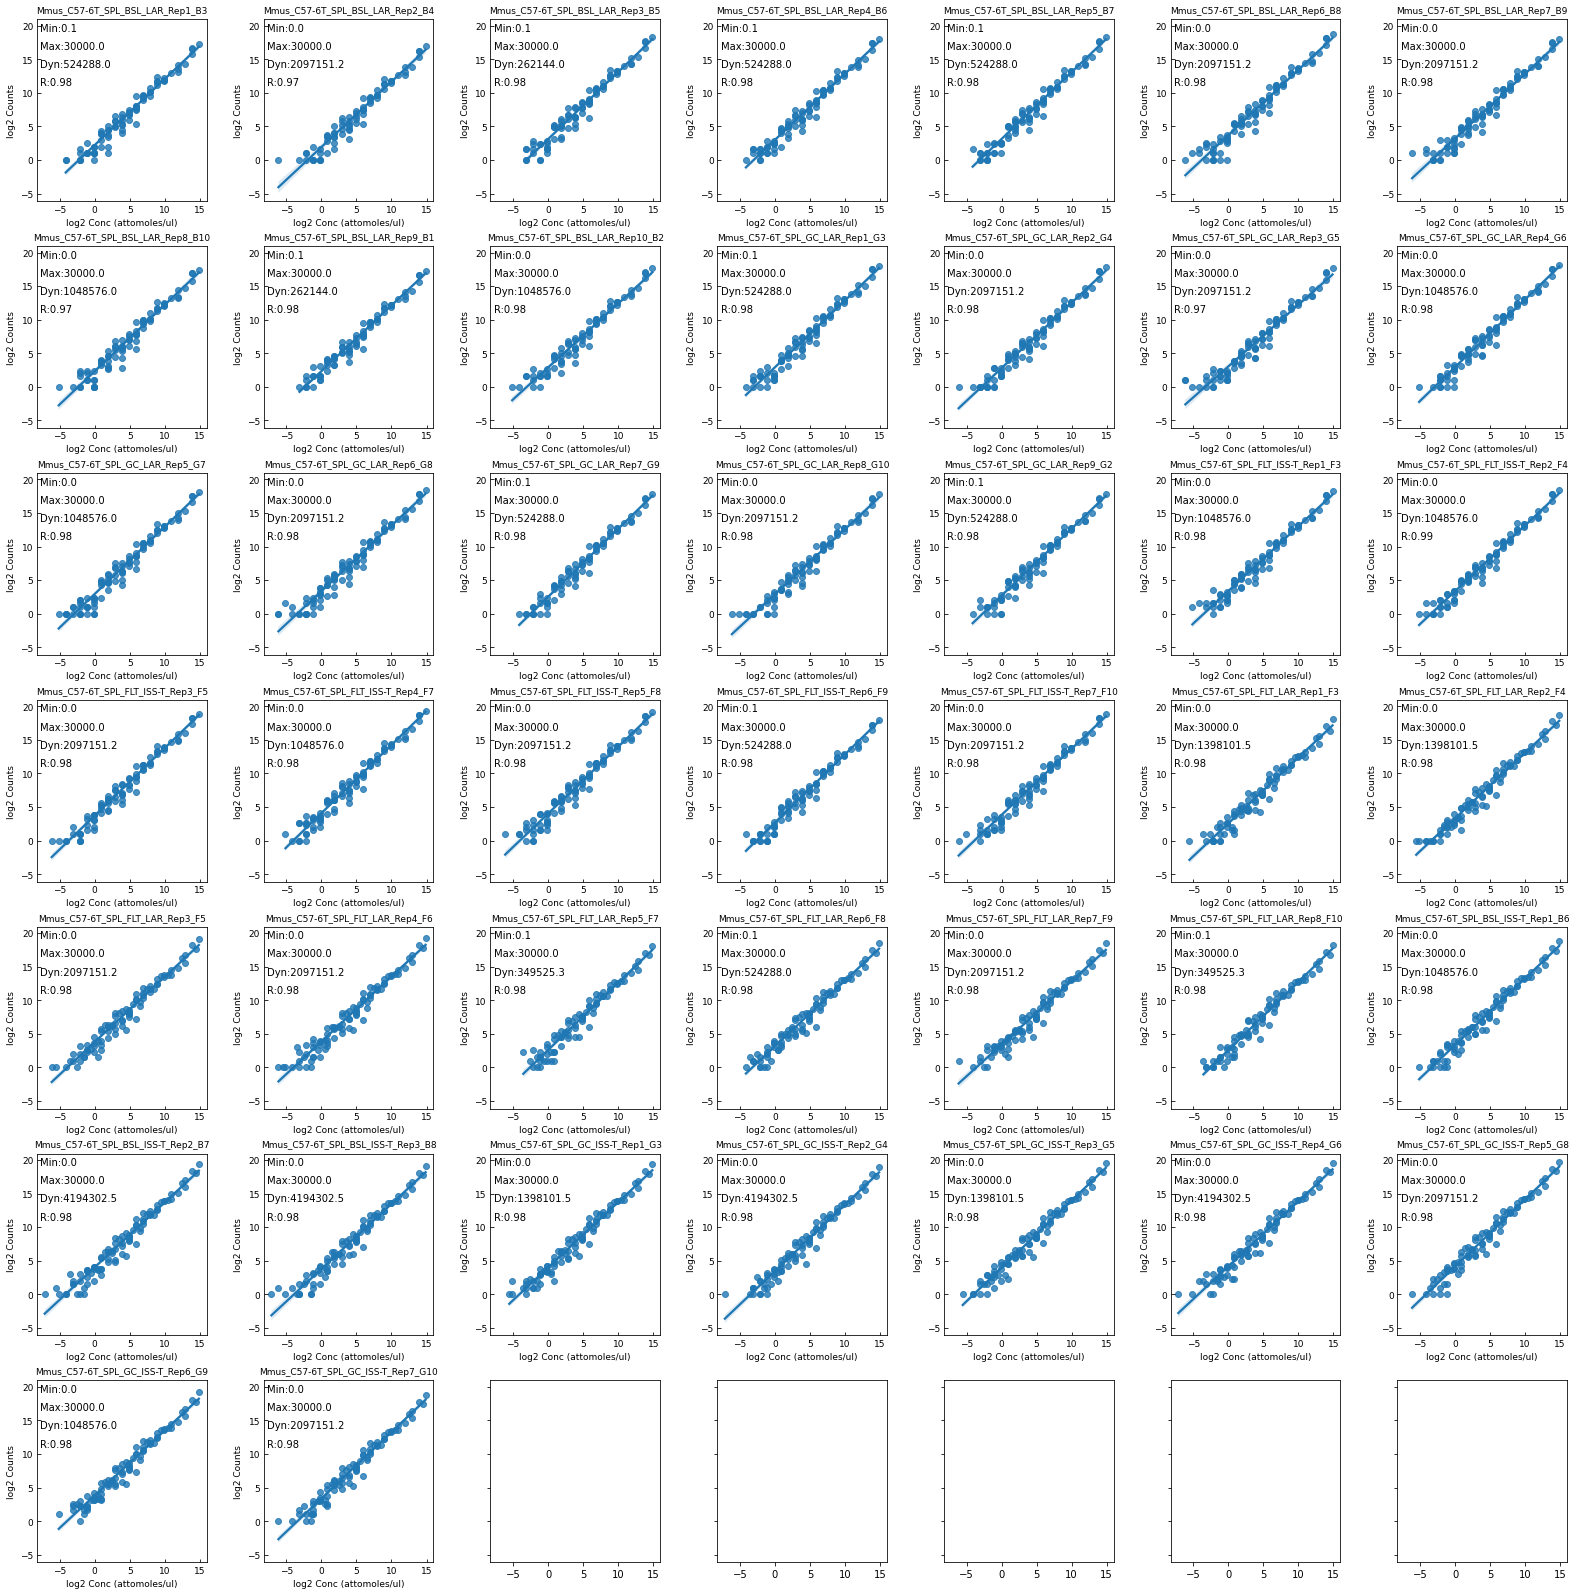

In [42]:
samples = []
mins = []
maxs = []
dyranges = []
rs = []

fig, axs = plt.subplots(side_size, side_size, figsize=(22,22), sharex='all', sharey='all');
fig.tight_layout(pad=1, w_pad=3.5, h_pad=3.5)

counter = 0
list2counter = 0
for ax in axs.flat:
    
    if(counter < len(columns_mix_1)):

      nonzero_counts = nonzero_counts_list_1[counter]
      xvalues = nonzero_counts['Conc']
      yvalues = nonzero_counts['Counts']

      sns.regplot(x=np.log2(xvalues), y=np.log2(yvalues), ax=ax);
      ax.set_title(all_columns[counter][-47:], fontsize=9);
      ax.set_xlabel('log2 Conc (attomoles/ul)', fontsize=9);
      ax.set_ylabel('log2 Counts', fontsize=9);
      ax.tick_params(direction='in', axis='both', labelsize=9, labelleft=True, labelbottom=True)
      samples.append(all_columns[counter])

      if(len(xvalues) == 0):
        mins.append('NaN')
        maxs.append('NaN')
        dyranges.append('NaN')
        rs.append('NaN')

    
      else:
        min = xvalues[0];
        mins.append(min)
        minimum = f'Min:{min:.1f}';
        max = xvalues[-1];
        maxs.append(max)
        maximum = f'Max:{max:.1f}';
        dynamic_range = max / min;
        dyranges.append(dynamic_range)
        dyn_str = f'Dyn:{dynamic_range:.1f}';

        ax.text(0.02, 0.98, minimum,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='black', fontsize=10);
      
        ax.text(0.02, 0.88, maximum,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='black', fontsize=10);
      
        ax.text(0.02, 0.78, dyn_str,verticalalignment='top',
                horizontalalignment='left',transform=ax.transAxes,
                color='black', fontsize=10);
      
        if(len(xvalues) == 1):
          rs.append('NaN')

        else:
          slope, intercept, r, p, se = linregress(np.log2(xvalues), y=np.log2(yvalues))
          r_str = f'R:{r:.2f}'
          rs.append(r)

          ax.text(0.02, 0.68, r_str, verticalalignment='top',
                  horizontalalignment='left',transform=ax.transAxes,
                  color='black', fontsize=10);
    
    elif(counter >= len(columns_mix_1) and counter < total_columns):
      
      nonzero_counts = nonzero_counts_list_2[list2counter]
      xvalues = nonzero_counts['Conc']
      yvalues = nonzero_counts['Counts']

      sns.regplot(x=np.log2(xvalues), y=np.log2(yvalues), ax=ax);
      ax.set_title(all_columns[counter][-47:], fontsize=9);
      ax.set_xlabel('log2 Conc (attomoles/ul)', fontsize=9);
      ax.set_ylabel('log2 Counts', fontsize=9);
      ax.tick_params(direction='in', axis='both', labelsize=9, labelleft=True, labelbottom=True);
      samples.append(all_columns[counter])


      if(len(xvalues) == 0):
        mins.append('NaN')
        maxs.append('NaN')
        dyranges.append('NaN')
        rs.append('NaN')
    
      else:
        min = xvalues[0];
        mins.append(min)
        minimum = f'Min:{min:.1f}';
        max = xvalues[-1];
        maxs.append(max)
        maximum = f'Max:{max:.1f}';
        dynamic_range = max / min;
        dyranges.append(dynamic_range)
        dyn_str = f'Dyn:{dynamic_range:.1f}';

        ax.text(0.02, 0.98, minimum,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='black', fontsize=10);
      
        ax.text(0.02, 0.88, maximum,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='black', fontsize=10);
      
        ax.text(0.02, 0.78, dyn_str,verticalalignment='top',
                horizontalalignment='left',transform=ax.transAxes,
                color='black', fontsize=10);
      
        if(len(xvalues) == 1):
          rs.append('NaN')
          
        else:
          slope, intercept, r, p, se = linregress(np.log2(xvalues), y=np.log2(yvalues));
          r_str = f'R:{r:.2f}';
          rs.append(r)

          ax.text(0.02, 0.68, r_str, verticalalignment='top',
                  horizontalalignment='left',transform=ax.transAxes,
                  color='black', fontsize=10);

      list2counter = list2counter + 1
    
    else:
      pass

    counter = counter + 1

In [43]:
# Directory for saved files
%mkdir ERCC_analysis

mkdir: cannot create directory ‘ERCC_analysis’: File exists


Print tables containing the dynamic range and R^2 values for each sample.

In [44]:
# Remember to change file names to GLDS# analyzing
# Select files w/ suffix _mqc* for MultiQC report 
stats = pd.DataFrame(list(zip(samples, mins, maxs, dyranges, rs)))
stats.columns = ['Samples', 'Min', 'Max', 'Dynamic range', 'R']
stats.to_csv('ERCC_analysis/ERCC_stats_GLDS-246.csv', index = False) 
stats.filter(items = ['Samples', 'Dynamic range']).to_csv('ERCC_analysis/ERCC_dynrange_GLDS-246_mqc.csv', index = False)
stats.filter(items = ['Samples', 'R']).to_csv('ERCC_analysis/ERCC_rsq_GLDS-246_mqc.csv', index = False)

## GeneLab Study Level ERCC 
This section shows an example of how the ERCC spike-ins can be used to assess the power of comparisons within a single study.

ERCC Mix 1 and Mix 2 are distributed so that half the samples receive Mix 1 spike-in and half receive Mix 2 spike-in. Transcripts in Mix 1 and Mix 2 are present at a known ratio, so we can determine how well these patterns are revealed in the dataset.

In [45]:
combined = sample_table.merge(assay_table, on='Sample Name')
combined = combined.set_index(combined['Sample Name'])
pd.set_option('max_columns', None)
combined

,Source Name,Sample Name,Characteristics[Organism],Term Source REF_x,Term Accession Number_x,Characteristics[Strain],Term Source REF.1_x,Term Accession Number.1_x,Comment[Animal Source],Characteristics[sex],Term Source REF.2_x,Term Accession Number.2_x,Characteristics[Age at Launch],Unit_x,Term Source REF.3_x,Term Accession Number.3_x,Characteristics[Diet],Term Source REF.4_x,Term Accession Number.4_x,Comment[Feeding Schedule],Characteristics[Material Type],Term Source REF.5_x,Term Accession Number.5_x,Protocol REF_x,Parameter Value[Enrichment material],Term Source REF.6_x,Term Accession Number.6_x,Factor Value[Spaceflight],Term Source REF.7_x,Term Accession Number.7_x,Factor Value[Duration],Unit.1_x,Term Source REF.8_x,Term Accession Number.8_x,Factor Value[Euthanasia Location],Term Source REF.9_x,Term Accession Number.9_x,Factor Value[Dissection Condition],Term Source REF.10_x,Term Accession Number.10_x,Protocol REF.1_x,Parameter Value[Euthanasia Method],Term Source REF.11_x,Term Accession Number.11_x,Parameter Value[Carcass Preservation Method],Unit.2_x,Term Source REF.12_x,Term Accession Number.12_x,Parameter Value[Carcass Weight],Unit.3_x,Term Source REF.13_x,Term Accession Number.13_x,Parameter Value[Sample Preservation Method],Term Source REF.14_x,Term Accession Number.14_x,Parameter Value[Sample Storage Temperature],Unit.4_x,Term Source REF.15_x,Term Accession Number.15_x,Comment[ALSDA Sample Name],Comment[Launch Date],Comment[Euthanasia Date],Comment[Dissection Date],Comment[ALSDA Source Name],Comment[ALSDA Biospecimen Subject ID],Comment[ALSDA Biospecimen ID],Protocol REF_y,Parameter Value[QA Instrument],Parameter Value[QA Assay],Parameter Value[QA Score],Unit_y,Term Source REF_y,Term Accession Number_y,Extract Name,Protocol REF.1_y,Parameter Value[Spike-in Quality Control],Term Source REF.1_y,Term Accession Number.1_y,Parameter Value[Spike-in Mix Number],Term Source REF.2_y,Term Accession Number.2_y,Protocol REF.2,Parameter Value[library selection],Parameter Value[library layout],Parameter Value[stranded],Parameter Value[Library QA Instrument],Term Source REF.3_y,Term Accession Number.3_y,Parameter Value[Library QA Assay],Term Source REF.4_y,Term Accession Number.4_y,Parameter Value[Fragment Size],Unit.1_y,Term Source REF.5_y,Term Accession Number.5_y,Protocol REF.3,Parameter Value[sequencing instrument],Parameter Value[base caller],Parameter Value[Read Length],Unit.2_y,Term Source REF.6_y,Term Accession Number.6_y,Assay Name,Parameter Value[rRNA Contamination],Unit.3_y,Term Source REF.7_y,Term Accession Number.7_y,Parameter Value[Read Depth],Unit.4_y,Term Source REF.8_y,Term Accession Number.8_y,Raw Data File,Protocol REF.4,Parameter Value[Fastqc File Names],Term Source REF.9_y,Term Accession Number.9_y,Parameter Value[Multiqc File Names],Term Source REF.10_y,Term Accession Number.10_y,Parameter Value[trimmed sequence data],Term Source REF.11_y,Term Accession Number.11_y,Parameter Value[Trimmed Sequence Data Fastqc File],Term Source REF.12_y,Term Accession Number.12_y,Parameter Value[Trimmed Sequence Data Multiqc File],Term Source REF.13_y,Term Accession Number.13_y,Parameter Value[Trimmed Report],Term Source REF.14_y,Term Accession Number.14_y,Parameter Value[aligned sequence data],Term Source REF.15_y,Term Accession Number.15_y,Parameter Value[Alignment Logs],Term Source REF.16,Term Accession Number.16,Parameter Value[Alignment QC Files],Term Source REF.17,Term Accession Number.17,Parameter Value[Raw Counts Data File],Term Source REF.18,Term Accession Number.18,Parameter Value[Normalized Counts Data File],Term Source REF.19,Term Accession Number.19,Parameter Value[differential expression analysis data transformation],Term Source REF.20,Term Accession Number.20,Parameter Value[ERCC Analyses],Term Source REF.21,Term Accession Number.21
Sample Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Mmus_C57-6T_SPL_BS

Create metadata table containing samples and their respective ERCC spike-in Mix number

In [46]:
# Sometimes Number in [Spike-in Mix Number] is spelled 'number' and this could cause error in mismatch search 
ERCCmetadata = combined[['Parameter Value[Spike-in Mix Number]']]
ERCCmetadata.index = ERCCmetadata.index.str.replace('-','_')
ERCCmetadata.columns = ['Mix']
#ERCCmetadata = ERCCmetadata.rename(columns={'Parameter Value[Spike-in Mix Number]':'Mix'})
ERCCmetadata

,Mix
Sample Name,
Mmus_C57_6T_SPL_BSL_LAR_Rep1_B3,Mix 1
Mmus_C57_6T_SPL_BSL_LAR_Rep2_B4,Mix 1
Mmus_C57_6T_SPL_BSL_LAR_Rep3_B5,Mix 1
Mmus_C57_6T_SPL_BSL_LAR_Rep4_B6,Mix 1
Mmus_C57_6T_SPL_BSL_LAR_Rep5_B7,Mix 1
Mmus_C57_6T_SPL_BSL_LAR_Rep6_B8,Mix 1
Mmus_C57_6T_SPL_BSL_LAR_Rep7_B9,Mix 1
Mmus_C57_6T_SPL_BSL_LAR_Rep8_B10,Mix 1
Mmus_C57_6T_SPL_BSL_LAR_Rep9_B1,Mix 1


Export ERCC sample metadata.

In [47]:
ERCCmetadata.to_csv('ERCC_analysis/ERCCmetadata.csv')

Export ERCC count data.

In [48]:
ercc_counts.columns = ercc_counts.columns.str.replace('-','_')
ERCCcounts = ercc_counts.loc[:,ERCCmetadata.index]
ERCCcounts.head()

Sample Name,Mmus_C57_6T_SPL_BSL_LAR_Rep1_B3,Mmus_C57_6T_SPL_BSL_LAR_Rep2_B4,Mmus_C57_6T_SPL_BSL_LAR_Rep3_B5,Mmus_C57_6T_SPL_BSL_LAR_Rep4_B6,Mmus_C57_6T_SPL_BSL_LAR_Rep5_B7,Mmus_C57_6T_SPL_BSL_LAR_Rep6_B8,Mmus_C57_6T_SPL_BSL_LAR_Rep7_B9,Mmus_C57_6T_SPL_BSL_LAR_Rep8_B10,Mmus_C57_6T_SPL_BSL_LAR_Rep9_B1,Mmus_C57_6T_SPL_BSL_LAR_Rep10_B2,Mmus_C57_6T_SPL_GC_LAR_Rep1_G3,Mmus_C57_6T_SPL_GC_LAR_Rep2_G4,Mmus_C57_6T_SPL_GC_LAR_Rep3_G5,Mmus_C57_6T_SPL_GC_LAR_Rep4_G6,Mmus_C57_6T_SPL_GC_LAR_Rep5_G7,Mmus_C57_6T_SPL_GC_LAR_Rep6_G8,Mmus_C57_6T_SPL_GC_LAR_Rep7_G9,Mmus_C57_6T_SPL_GC_LAR_Rep8_G10,Mmus_C57_6T_SPL_GC_LAR_Rep9_G2,Mmus_C57_6T_SPL_FLT_LAR_Rep1_F3,Mmus_C57_6T_SPL_FLT_LAR_Rep2_F4,Mmus_C57_6T_SPL_FLT_LAR_Rep3_F5,Mmus_C57_6T_SPL_FLT_LAR_Rep4_F6,Mmus_C57_6T_SPL_FLT_LAR_Rep5_F7,Mmus_C57_6T_SPL_FLT_LAR_Rep6_F8,Mmus_C57_6T_SPL_FLT_LAR_Rep7_F9,Mmus_C57_6T_SPL_FLT_LAR_Rep8_F10,Mmus_C57_6T_SPL_BSL_ISS_T_Rep1_B6,Mmus_C57_6T_SPL_BSL_ISS_T_Rep2_B7,Mmus_C57_6T_SPL_BSL_ISS_T_Rep3_B8,Mmus_C57_6T_SPL_GC_ISS_T_Rep1_G3,Mmus_C57_6T_SPL_GC_ISS_T_Rep2_G4,Mmus_C57_6T_SPL_GC_ISS_T_Rep3_G5,Mmus_C57_6T_SPL_GC_ISS_T_Rep4_G6,Mmus_C57_6T_SPL_GC_ISS_T_Rep5_G8,Mmus_C57_6T_SPL_GC_ISS_T_Rep6_G9,Mmus_C57_6T_SPL_GC_ISS_T_Rep7_G10,Mmus_C57_6T_SPL_FLT_ISS_T_Rep1_F3,Mmus_C57_6T_SPL_FLT_ISS_T_Rep2_F4,Mmus_C57_6T_SPL_FLT_ISS_T_Rep3_F5,Mmus_C57_6T_SPL_FLT_ISS_T_Rep4_F7,Mmus_C57_6T_SPL_FLT_ISS_T_Rep5_F8,Mmus_C57_6T_SPL_FLT_ISS_T_Rep6_F9,Mmus_C57_6T_SPL_FLT_ISS_T_Rep7_F10
Gene_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ERCC-00130,158095.0,125241.0,316764.0,269716.0,316124.0,423452.0,277449.0,179421.0,162616.0,209413.0,273656.0,225234.0,202596.0,296275.0,297167.0,345758.0,234823.0,233381.0,241494.0,49115.0,79678.0,111010.0,114442.0,57834.0,69374.0,72043.0,58534.0,85969.0,128111.0,108104.0,123641.0,93755.0,143664.0,141355.0,157658.0,110521.0,88247.0,327144.0,345689.0,489558.0,667795.0,593790.0,259070.0,493641.0
ERCC-00096,99682.0,80487.0,191642.0,173109.0,200475.0,283467.0,179536.0,122496.0,99416.0,122361.0,185269.0,148422.0,126765.0,183875.0,180592.0,228050.0,141887.0,142903.0,143366.0,141359.0,219104.0,298288.0,313282.0,138956.0,177352.0,188553.0,154019.0,232395.0,339027.0,280972.0,339158.0,244250.0,373800.0,366672.0,420914.0,279186.0,221603.0,206545.0,227512.0,318256.0,435803.0,374814.0,152659.0,306861.0
ERCC-00002,90237.0,74520.0,207244.0,182546.0,206279.0,292182.0,190943.0,129542.0,98156.0,134102.0,184123.0,150979.0,133837.0,194152.0,196307.0,236988.0,153847.0,151630.0,152138.0,280085.0,435034.0,596870.0,644796.0,262554.0,369889.0,387471.0,321845.0,465289.0,684510.0,566971.0,675841.0,510174.0,764799.0,737525.0,860674.0,590510.0,465096.0,208286.0,231301.0,324061.0,442326.0,381440.0,152583.0,312443.0
ERCC-00074,53674.0,40470.0,102096.0,81464.0,95002.0,141302.0,93088.0,56496.0,51217.0,71829.0,80288.0,68343.0,63183.0,94495.0,98804.0,114621.0,76129.0,77543.0,78292.0,83845.0,149595.0,196135.0,216730.0,107789.0,137248.0,141264.0,114726.0,166331.0,261792.0,213796.0,242680.0,199514.0,288862.0,292727.0,326577.0,219534.0,183870.0,112299.0,107293.0,163985.0,234612.0,197550.0,87817.0,162039.0
ERCC-00004,20773.0,15344.0,42041.0,33501.0,39613.0,61984.0,41598.0,25953.0,20150.0,28158.0,32316.0,27449.0,26967.0,39869.0,40775.0,48649.0,31028.0,32409.0,33557.0,5751.0,10286.0,13158.0,15872.0,7433.0,9180.0,10045.0,8154.0,11273.0,18273.0,14729.0,16695.0,14390.0,19863.0,20264.0,22265.0,14754.0,12533.0,46418.0,47273.0,68787.0,96913.0,80440.0,35153.0,65958.0


In [50]:
ERCCcounts.to_csv('ERCC_analysis/ERCCcounts.csv')

## Perform DESeq2 analysis of ERCC counts

Switch to R script to perform DE on ERCC unnormalized counts (i.e. run the GLDS-246_ERCC_analysis.R script in R, which contains all of the commands in this section). Contrast (pair-wise) Mix 1 and Mix 2 comparison returns mean normalized counts, log2FC (fold change), p-value, adj. p-value.

In [51]:
%load_ext rpy2.ipython

In [52]:
%%R
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DESeq2")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/BiocManager_1.30.16.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 262502 bytes (256 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


Update all/some/none? [a/s/n]: a


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/backports_1.4.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 26072 bytes (25 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console

In [53]:
%%R
library("DESeq2")

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


R[write to console]: 
Attaching package: ‘S4Vectors’


R[write to console]: The following objects are masked from ‘package:base’:

    expand.grid, I, unname


R[write to console]: Loading r

In [54]:
%%R
cts <- as.matrix(read.csv('ERCC_analysis/ERCCcounts.csv',sep=",",row.names="Gene_ID"))
coldata <- read.csv('ERCC_analysis/ERCCmetadata.csv', row.names=1)

In [55]:
%%R
coldata$Mix <- factor(coldata$Mix)

In [56]:
%%R
all(rownames(coldata) == colnames(cts))

[1] TRUE


In [57]:
%%R
dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData = coldata,
                              design = ~ Mix)
dds

R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



class: DESeqDataSet 
dim: 92 44 
metadata(1): version
assays(1): counts
rownames(92): ERCC-00130 ERCC-00096 ... ERCC-00057 ERCC-00048
rowData names(0):
colnames(44): Mmus_C57_6T_SPL_BSL_LAR_Rep1_B3
  Mmus_C57_6T_SPL_BSL_LAR_Rep2_B4 ... Mmus_C57_6T_SPL_FLT_ISS_T_Rep6_F9
  Mmus_C57_6T_SPL_FLT_ISS_T_Rep7_F10
colData names(1): Mix


In [58]:
%%R
dds <- DESeq(dds)
res <- results(dds, contrast=c("Mix","Mix 1","Mix 2"))
res

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: final dispersion estimates

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '

log2 fold change (MLE): Mix Mix 1 vs Mix 2 
Wald test p-value: Mix Mix 1 vs Mix 2 
DataFrame with 92 rows and 6 columns
            baseMean log2FoldChange     lfcSE       stat       pvalue
           <numeric>      <numeric> <numeric>  <numeric>    <numeric>
ERCC-00130    231516       2.318125 0.0156369   148.2470  0.00000e+00
ERCC-00096    202934       0.258201 0.0217266    11.8841  1.43122e-32
ERCC-00002    283560      -0.722205 0.0260965   -27.6744 1.42055e-168
ERCC-00074    121327      -0.275430 0.0268581   -10.2550  1.12377e-24
ERCC-00004     31205       2.308270 0.0326300    70.7407  0.00000e+00
...              ...            ...       ...        ...          ...
ERCC-00142  0.753703      0.5379269  0.608354  0.8842328   0.37657056
ERCC-00061  0.816122     -0.3929911  0.513345 -0.7655497   0.44394427
ERCC-00083  0.507636      1.9590067  0.669460  2.9262481   0.00343077
ERCC-00057  0.215270     -0.0828384  0.869388 -0.0952836   0.92408955
ERCC-00048  0.139208      0.5934252  1.9

Export DESeq2 analysis results and normalized ERCC counts.

In [59]:
%%R
write.csv(res, 'ERCC_analysis/ERCC_DESeq2.csv')

In [60]:
%%R
normcounts = counts(dds, normalized=TRUE)
write.csv(normcounts, 'ERCC_analysis/ERCC_normcounts.csv')

## Analyze DESeq2 results

In [61]:
import pandas as pd
from urllib.request import urlopen, quote, urlretrieve
import seaborn as sns
import matplotlib.pyplot as plt

In [62]:
deseq2out = pd.read_csv('ERCC_analysis/ERCC_DESeq2.csv', index_col=0)
#deseq2out.index = deseq2out.index.str.replace('_','-')
deseq2out.rename(columns ={'baseMean' : 'meanNormCounts'}, inplace = True)
deseq2out.head()

,meanNormCounts,log2FoldChange,lfcSE,stat,pvalue,padj
ERCC-00130,231516.044015,2.318125,0.015637,148.247022,0.000000e+00,0.000000e+00
ERCC-00096,202933.875783,0.258201,0.021727,11.884127,1.431220e-32,3.465058e-32
ERCC-00002,283560.272884,-0.722205,0.026097,-27.674380,1.420555e-168,7.687708e-168
ERCC-00074,121326.615189,-0.275430,0.026858,-10.254999,1.123774e-24,2.521639e-24
ERCC-00004,31205.021595,2.308270,0.032630,70.740726,0.000000e+00,0.000000e+00


In [63]:
# Get ERCC files
ercc_url = 'https://assets.thermofisher.com/TFS-Assets/LSG/manuals/cms_095046.txt'
filehandle, _ = urlretrieve(ercc_url)
ercc_table = pd.read_csv(filehandle, '\t', index_col='ERCC ID')
ercc_table.head(n=3)

,Re-sort ID,subgroup,concentration in Mix 1 (attomoles/ul),concentration in Mix 2 (attomoles/ul),expected fold-change ratio,log2(Mix 1/Mix 2)
ERCC ID,,,,,,
ERCC-00130,1,A,30000.0,7500.00,4.0,2.0
ERCC-00004,2,A,7500.0,1875.00,4.0,2.0
ERCC-00136,3,A,1875.0,468.75,4.0,2.0


In [64]:
combined = deseq2out.merge(ercc_table, left_index=True, right_index=True)
combined.head()

,meanNormCounts,log2FoldChange,lfcSE,stat,pvalue,padj,Re-sort ID,subgroup,concentration in Mix 1 (attomoles/ul),concentration in Mix 2 (attomoles/ul),expected fold-change ratio,log2(Mix 1/Mix 2)
ERCC-00130,231516.044015,2.318125,0.015637,148.247022,0.000000e+00,0.000000e+00,1,A,30000.0,7500.0,4.00,2.00
ERCC-00096,202933.875783,0.258201,0.021727,11.884127,1.431220e-32,3.465058e-32,24,B,15000.0,15000.0,1.00,0.00
ERCC-00002,283560.272884,-0.722205,0.026097,-27.674380,1.420555e-168,7.687708e-168,70,D,15000.0,30000.0,0.50,-1.00
ERCC-00074,121326.615189,-0.275430,0.026858,-10.254999,1.123774e-24,2.521639e-24,47,C,15000.0,22500.0,0.67,-0.58
ERCC-00004,31205.021595,2.308270,0.032630,70.740726,0.000000e+00,0.000000e+00,2,A,7500.0,1875.0,4.00,2.00


In [65]:
# P-value and adj. p-value cutoff at 10^-3
combined['cleaned_padj'] = combined['padj']
combined.loc[(combined.cleaned_padj < 0.001),'cleaned_padj']=0.001

combined['cleaned_pvalue'] = combined['pvalue']
combined.loc[(combined.cleaned_pvalue < 0.001),'cleaned_pvalue']=0.001

combined.head()

,meanNormCounts,log2FoldChange,lfcSE,stat,pvalue,padj,Re-sort ID,subgroup,concentration in Mix 1 (attomoles/ul),concentration in Mix 2 (attomoles/ul),expected fold-change ratio,log2(Mix 1/Mix 2),cleaned_padj,cleaned_pvalue
ERCC-00130,231516.044015,2.318125,0.015637,148.247022,0.000000e+00,0.000000e+00,1,A,30000.0,7500.0,4.00,2.00,0.001,0.001
ERCC-00096,202933.875783,0.258201,0.021727,11.884127,1.431220e-32,3.465058e-32,24,B,15000.0,15000.0,1.00,0.00,0.001,0.001
ERCC-00002,283560.272884,-0.722205,0.026097,-27.674380,1.420555e-168,7.687708e-168,70,D,15000.0,30000.0,0.50,-1.00,0.001,0.001
ERCC-00074,121326.615189,-0.275430,0.026858,-10.254999,1.123774e-24,2.521639e-24,47,C,15000.0,22500.0,0.67,-0.58,0.001,0.001
ERCC-00004,31205.021595,2.308270,0.032630,70.740726,0.000000e+00,0.000000e+00,2,A,7500.0,1875.0,4.00,2.00,0.001,0.001


In [66]:
# Remember to change file name to GLDS# analyzing
combined.filter(items = ['ERCC ID', 'meanNormCounts', 'cleaned_pvalue','cleaned_padj']).to_csv('ERCC_analysis/ERCC_lodr_GLDS-246_mqc.csv')

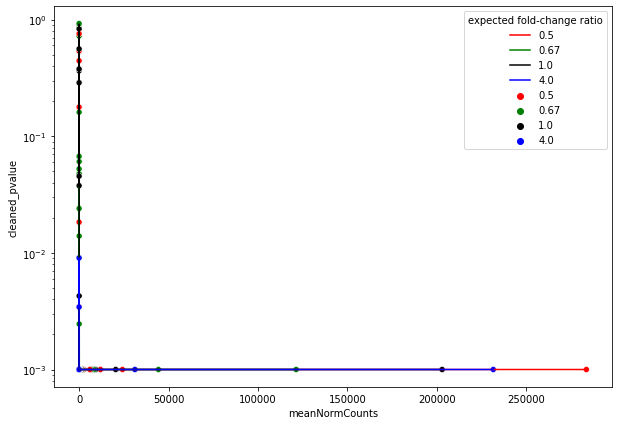

In [67]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.scatterplot(data=combined, x="meanNormCounts", y="cleaned_pvalue",
            hue="expected fold-change ratio",
                palette=['red','green','black','blue'], ax=ax)

sns.lineplot(data=combined, x="meanNormCounts", y="cleaned_pvalue",
            hue="expected fold-change ratio",
                palette=['red','green','black','blue'], ax=ax)

#g.set_xscale("log", base=2)
ax.set_xscale("linear");
ax.set_yscale("log");

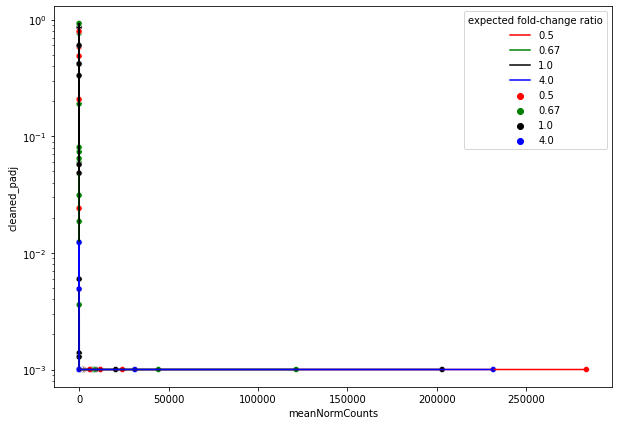

In [68]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.scatterplot(data=combined, x="meanNormCounts", y="cleaned_padj",
            hue="expected fold-change ratio",
                palette=['red','green','black','blue'], ax=ax)

sns.lineplot(data=combined, x="meanNormCounts", y="cleaned_padj",
            hue="expected fold-change ratio",
                palette=['red','green','black','blue'], ax=ax)

#g.set_xscale("log", base=2)
ax.set_xscale("linear");
ax.set_yscale("log");

Run MultiQC report on select *mqc files separately in command line. 